In [1]:
import pypsa
import pickle 
import numpy as np
import pandas as pd
import os
from scipy import stats
from typing import Callable
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
import warnings

from sklearn.linear_model import Lasso, LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from helper_functions import split_list, get_result_array, get_result_dict, plot_generator, plot_feature_array, plot_results, plot_all_results, MAD

plt.rcParams.update({'font.size': 20})

In [2]:
colors = {'orange1': '#FF800E', 'orange2': '#C85200', 'orange3': '#FFBC79', 'orange4': '#A7886D', 
          'blue1': '#006BA4', 'blue2': '#5F9ED1', 'blue3': '#A2C8EC', 'blue4': '#3c6174',
          'grey1': '#ABABAB', 'grey2': '#595959', 'grey3': '#898989', 'grey4': '#CFCFCF'}

In [ ]:
n = pypsa.Network("networks/elec_s_80_ec_lcopt_Co2L-24H_2011_15.nc")

Import result dictionaries

In [ ]:
with open('result_dict_2m.pkl', 'rb') as f:
    result_dict_2m = pickle.load(f)

In [ ]:
with open('result_dict_1w.pkl', 'rb') as f:
    result_dict_1w = pickle.load(f)

Import network split

In [ ]:
directory = os.fsencode('netw_split_2m')
n_files = len([f for f in os.listdir(directory)])
netw_split_2m = [pypsa.Network(f'netw_split_2m/{i}.nc') for i in range(n_files)]

In [ ]:
directory = os.fsencode('netw_split_1w')
n_files = len([f for f in os.listdir(directory)])
netw_split_1w = [pypsa.Network(f'netw_split_1w/{i}.nc') for i in range(n_files)]

In [3]:
class ResultVectors(dict):
    def __setitem__(self, key, file_name):
        with open(f'{file_name}.pkl', 'rb') as f:
            result_dict = pickle.load(f)
        super().__setitem__(key, result_dict)

class NetworkSplits(dict):
    def __setitem__(self, key, directory_name):
        directory = os.fsencode(directory_name)
        n_files = len([f for f in os.listdir(directory)])
        netw_split = [pypsa.Network(f'{directory_name}/{i}.nc') for i in range(n_files)]
        super().__setitem__(key, netw_split)

In [4]:
split_keys = ['2m', '1w']
result_vectors = ResultVectors()
netw_splits = NetworkSplits()
for key in split_keys:
    result_vectors[key] = f'result_dict_{key}'
    netw_splits[key] = f'netw_split_{key}'

INFO:pypsa.io:Imported network 0.nc has buses, carriers, generators, global_constraints, lines, links, loads, shapes, storage_units, stores
INFO:pypsa.io:Imported network 1.nc has buses, carriers, generators, global_constraints, lines, links, loads, shapes, storage_units, stores
INFO:pypsa.io:Imported network 2.nc has buses, carriers, generators, global_constraints, lines, links, loads, shapes, storage_units, stores
INFO:pypsa.io:Imported network 3.nc has buses, carriers, generators, global_constraints, lines, links, loads, shapes, storage_units, stores
INFO:pypsa.io:Imported network 4.nc has buses, carriers, generators, global_constraints, lines, links, loads, shapes, storage_units, stores
INFO:pypsa.io:Imported network 5.nc has buses, carriers, generators, global_constraints, lines, links, loads, shapes, storage_units, stores
INFO:pypsa.io:Imported network 6.nc has buses, carriers, generators, global_constraints, lines, links, loads, shapes, storage_units, stores
INFO:pypsa.io:Import

In [5]:
class Experiment():
    def __init__(self, name:str, netw_splits: NetworkSplits, result_vectors=None, feature_matrices=None, feature_names=None, feature_colors=None) -> None:
        self.name = name
        self.split_names = netw_splits.keys()
        self.netw_splits = netw_splits
        if result_vectors is None or self.split_names != result_vectors.keys():
            result_vectors = ResultVectors()
            for key, netw_split in netw_splits.items():
                result_vectors[key] = get_result_dict(netw_split)
        self.result_vectors=result_vectors
        self.feature_matrices = feature_matrices
        self.feature_names = feature_names
        self.feature_colors = feature_colors
        self.results = dict()
    
    def create_features(self, extract_feature_func: Callable, feature_names:str=None, feature_colors=None):
        if self.feature_matrices is None:
            self.feature_matrices = dict()
        for split in self.split_names:
            matrix = []
            for netw in self.netw_splits[split]:
                matrix.append(extract_feature_func(netw))
            scaler = StandardScaler().fit(matrix)
            matrix = scaler.transform(matrix)
            self.feature_matrices[split] = matrix
        self.feature_names = feature_names
        self.feature_colors = feature_colors
        if self.feature_names is None:
            self.feature_names = [f'feature {i+1}' for i in range(len(matrix[0]))]

    
    def run_algorithms(self):
        for split in self.split_names:
            coefficients = pd.DataFrame(index=self.feature_names)
            weights = pd.DataFrame(index=self.feature_names)
            MADs = []

            for result_key, result_array in self.result_vectors[split].items():
                lasso_regr = LassoCV()
                RF_regr = RandomForestRegressor(max_features="sqrt")
                with warnings.catch_warnings(action="ignore"):
                    lasso_regr.fit(self.feature_matrices[split], result_array)
                    RF_regr.fit(self.feature_matrices[split], result_array)
                
                coefficients[result_key] = lasso_regr.coef_
                weights[result_key] = RF_regr.feature_importances_

                MADs.append(MAD(result_array)) 
                
            self.results[split] = (coefficients, weights, MADs)
    
    def get_color_dict(self):
        return {feature: self.feature_colors[i] for i, feature in enumerate(self.feature_names)}

    def plot_features(self, split:str):
        plot_feature_array(
            self.feature_matrices[split], 
            file_name=f'{self.name}_{split}_features',
            feature_names=self.feature_names,
            feature_colors=self.feature_colors
        )
    
    def plot_results(self, split:str):
        coefficients, weights, MADs = self.results[split]
        plot_results(coefficients, MADs=MADs, file_name=f'{self.name}_{split}_Lasso', feature_colors=self.get_color_dict())
        plot_results(weights, MADs=MADs, file_name=f'{self.name}_{split}_Random_Forests', feature_colors=self.get_color_dict())

    def plot_all_results(self):
        all_results = []
        for _,(coefficients, weights, _) in self.results.items():
            all_results.append(coefficients)
            all_results.append(weights) 
        plot_all_results(all_results, file_name=f'{self.name}_all_results', feature_colors=self.get_color_dict())


# Basic Information

In [ ]:
n.plot()
plt.savefig(f"plots/PyPSA-germany.pdf", format="pdf", bbox_inches="tight")

In [ ]:
n.buses['x']['DE0 0']

In [ ]:
n.buses['y']['DE0 0']

In [ ]:
n.statistics()

In [ ]:
n.generators_t.p_max_pu

In [ ]:
len(list(n.snapshots))

In [ ]:
plot_generator(netw_split_2m, 'DE0 0 solar', 'generator_solar_2m')
plot_generator(netw_split_1w, 'DE0 0 solar', 'generator_solar_1w')

# Network Split

## ~ 2 Month

In [ ]:
snapshot_splits = split_list(list=n.snapshots, n=30)
netw_split_2m = []
for snapshot_split in snapshot_splits:
    netw_copy = n.copy()
    netw_copy.set_snapshots(snapshots=snapshot_split)
    netw_copy.optimize(snapshot_split, solver_name="gurobi")
    netw_split_2m.append(netw_copy)

Export network split:

In [ ]:
for i, netw in enumerate(netw_split_2m):
    netw.export_to_netcdf(path=f'netw_split_2m/{i}.nc')

Import network split:

In [ ]:
directory = os.fsencode('netw_split_2m')
n_files = len([f for f in os.listdir(directory)])
netw_split_2m = [pypsa.Network(f'netw_split_2m/{i}.nc') for i in range(n_files)]

Create and export result dictonary

In [ ]:
result_dict_2m = get_result_dict(netw_split_2m)
print(result_dict_2m)
with open('result_dict_2m.pkl', 'wb') as f:
    pickle.dump(result_dict_2m, f)

## ~ 1 week (2011)

In [ ]:
snapshots = [s for s in n.snapshots if s.year==2012]
snapshot_splits = split_list(list=snapshots, n=52)
netw_split_1w_2012 = []
for snapshot_split in snapshot_splits:
    netw_copy = n.copy()
    netw_copy.set_snapshots(snapshots=snapshot_split)
    netw_copy.optimize(snapshot_split, solver_name="gurobi")
    netw_split_1w_2012.append(netw_copy)

## ~ 1 week (2011-2015)

In [ ]:
snapshot_splits = split_list(list=n.snapshots, n=260)
netw_split_1w = []
for snapshot_split in snapshot_splits:
    netw_copy = n.copy()
    netw_copy.set_snapshots(snapshots=snapshot_split)
    # netw_copy.optimize(snapshot_split, solver_name="gurobi")
    netw_split_1w.append(netw_copy)

In [ ]:
len(netw_split_1w)

In [ ]:
for netw in netw_split_1w:
    netw_copy.optimize(solver_name="gurobi")

In [ ]:
for i, netw in enumerate(netw_split_1w):
    netw.export_to_netcdf(path=f'netw_split_1w/{i}.nc')

In [ ]:
directory = os.fsencode('netw_split_1w')
n_files = len([f for f in os.listdir(directory)])
netw_split_1w = [pypsa.Network(f'netw_split_1w/{i}.nc') for i in range(n_files)]

In [ ]:
result_dict_1w = get_result_dict(netw_split_1w)
with open('result_dict_1w.pkl', 'wb') as f:
    pickle.dump(result_dict_1w, f)

In [ ]:
plot_generator(netw_split_1w, 'DE0 0 onwind')

# Optimize Result Array

In [ ]:
results = [[np.mean(netw.statistics()[column]) for column in netw.statistics()] for netw in netw_splits]

In [ ]:
result_keys = [column for column in n.statistics()]

In [ ]:
result_features = np.array(results).T
for i, y in enumerate(result_features):
    plt.plot(np.arange(len(y)), stats.zscore(y), label=result_keys[i])
plt.legend()
plt.show()

In [ ]:
def plot_result_array(i):
    plt.plot(np.arange(len(result_features[i])), stats.zscore(result_features[i]), label=result_keys[i])
    plt.show()
plot_result_array(0)

In [ ]:


var = [MAD(stats.zscore(result)) for result in result_features]
print(var)
sorted_var = np.argsort(var)
for i in sorted_var:
    print(f"{i}: {result_keys[i]} | {var[i]}")

# Optimization 

In [ ]:
def run_algorithms(feature_array, result_dict=None, netw_split=None, feature_names=None):
    coefficients = pd.DataFrame(index=feature_names)
    weights = pd.DataFrame(index=feature_names)
    MADs = []

    if result_dict is None:
        result_dict = get_result_dict(netw_split)

    for result_key, result_array in result_dict.items():
        lasso_regr = LassoCV()
        RF_regr = RandomForestRegressor(max_features="sqrt")
        with warnings.catch_warnings(action="ignore"):
            lasso_regr.fit(feature_array, result_array)
            RF_regr.fit(feature_array, result_array)
        
        coefficients[result_key] = lasso_regr.coef_
        weights[result_key] = RF_regr.feature_importances_

        MADs.append(MAD(result_array)) 
        
    return coefficients, weights, MADs

## simple

In [6]:
simple_experiment = Experiment('simple', netw_splits, result_vectors)

feature_names = ['solar', 'onwind', 'offwind-ac', 'offwind-dc']
feature_colors = [colors['orange1'], colors['blue1'], colors['blue2'], colors['blue3']]

def get_feature(df: pd.DataFrame, search: str):
    filtered_df = df.filter(like=search, axis=1)
    return np.mean(np.array(filtered_df), axis=(0,1))

def get_features(netw: pypsa.Network):
    feature_data = netw.generators_t.p_max_pu
    return [get_feature(feature_data, key_word) for key_word in feature_names]

simple_experiment.create_features(get_features, feature_names, feature_colors)

simple_experiment.run_algorithms()

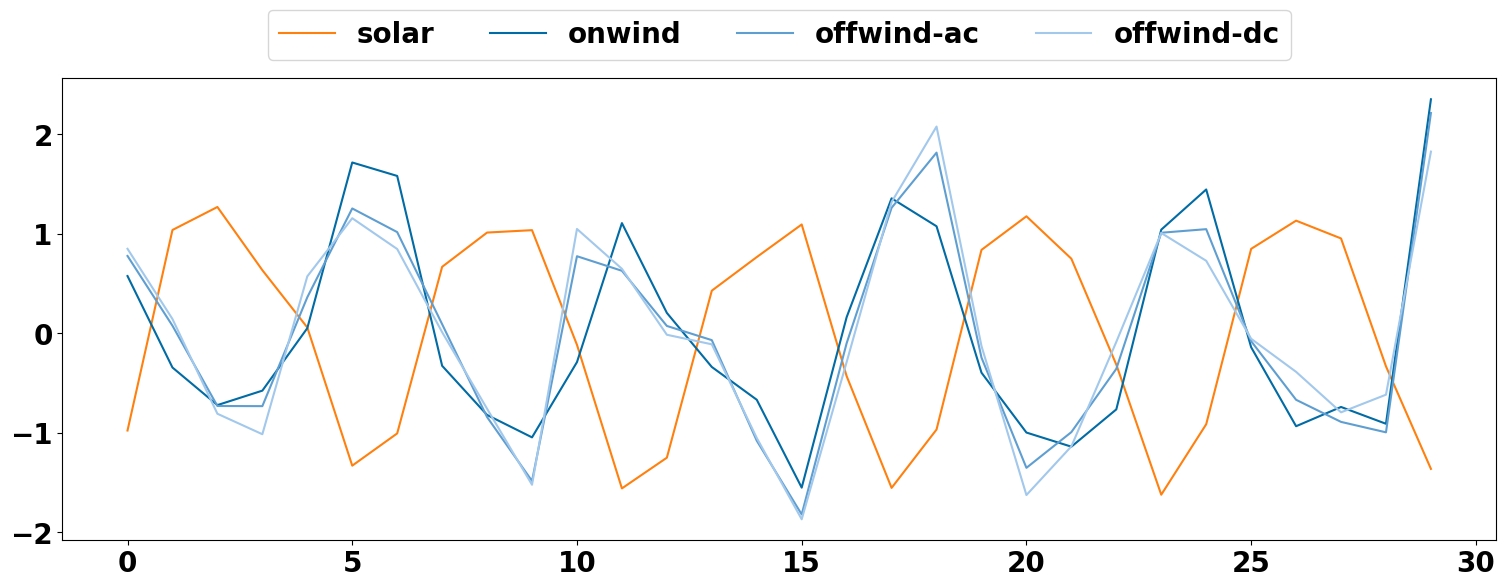

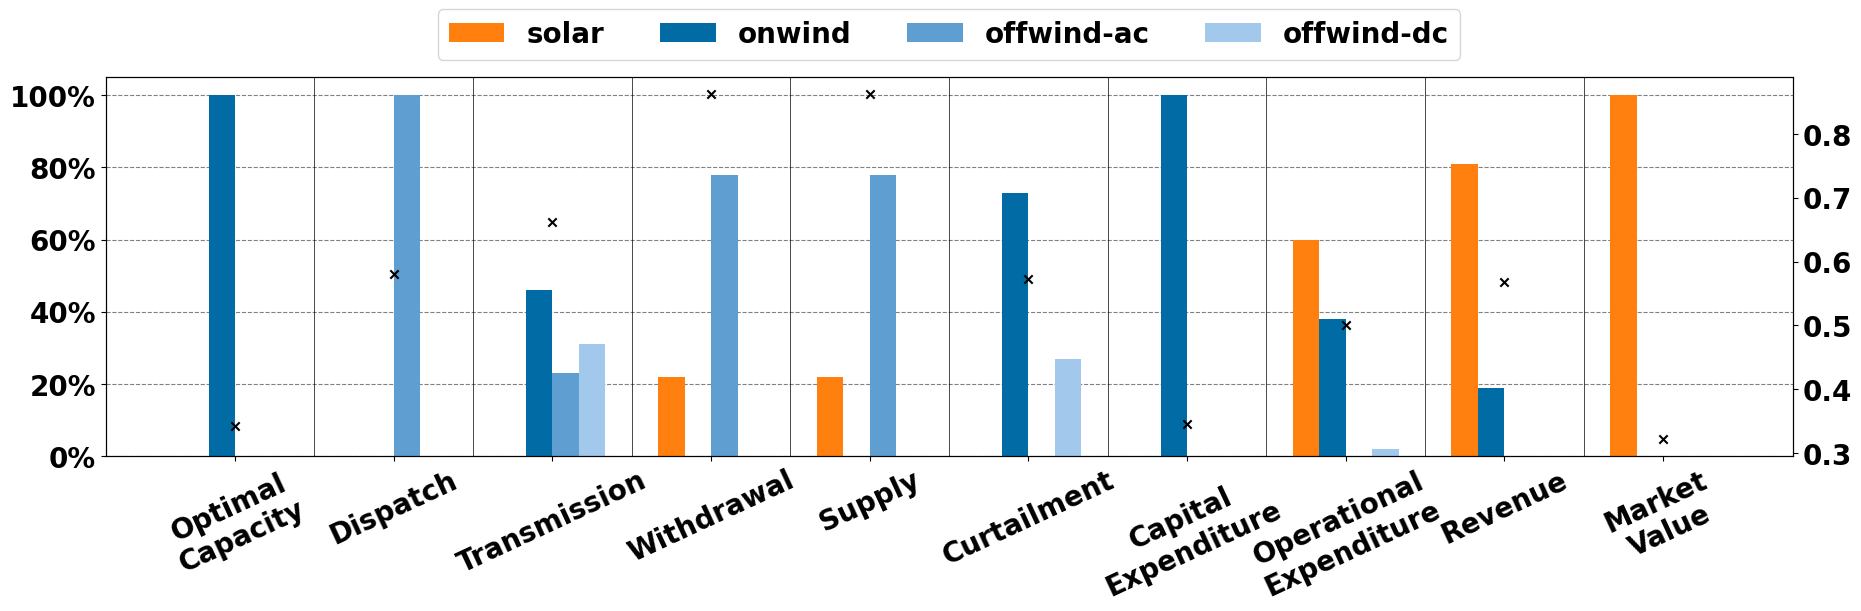

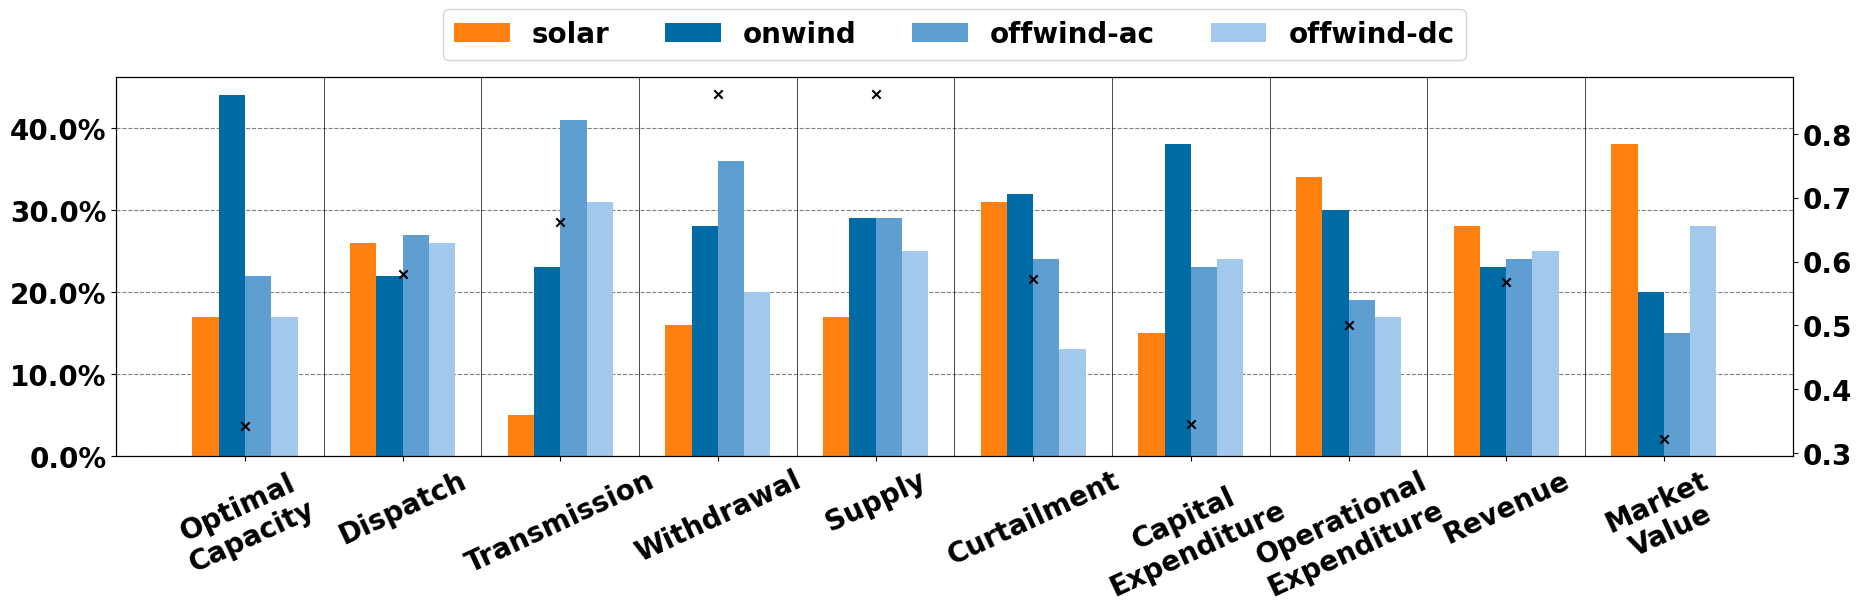

In [7]:
simple_experiment.plot_features('2m')
simple_experiment.plot_results('2m')

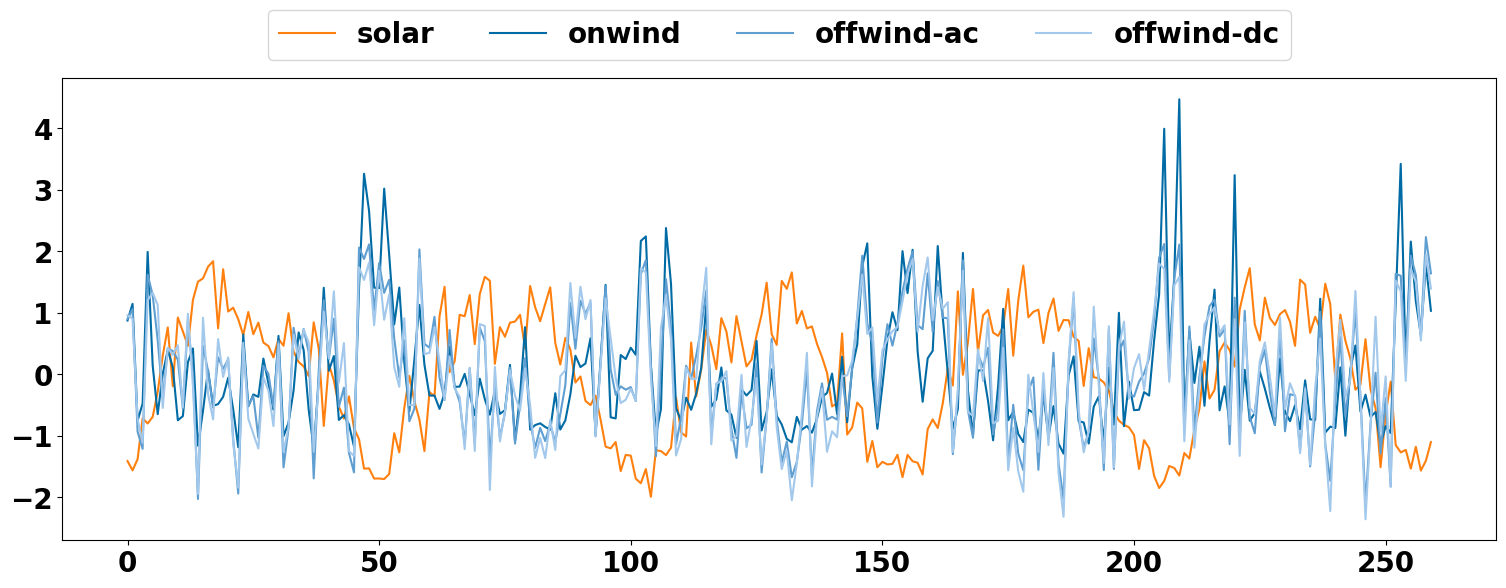

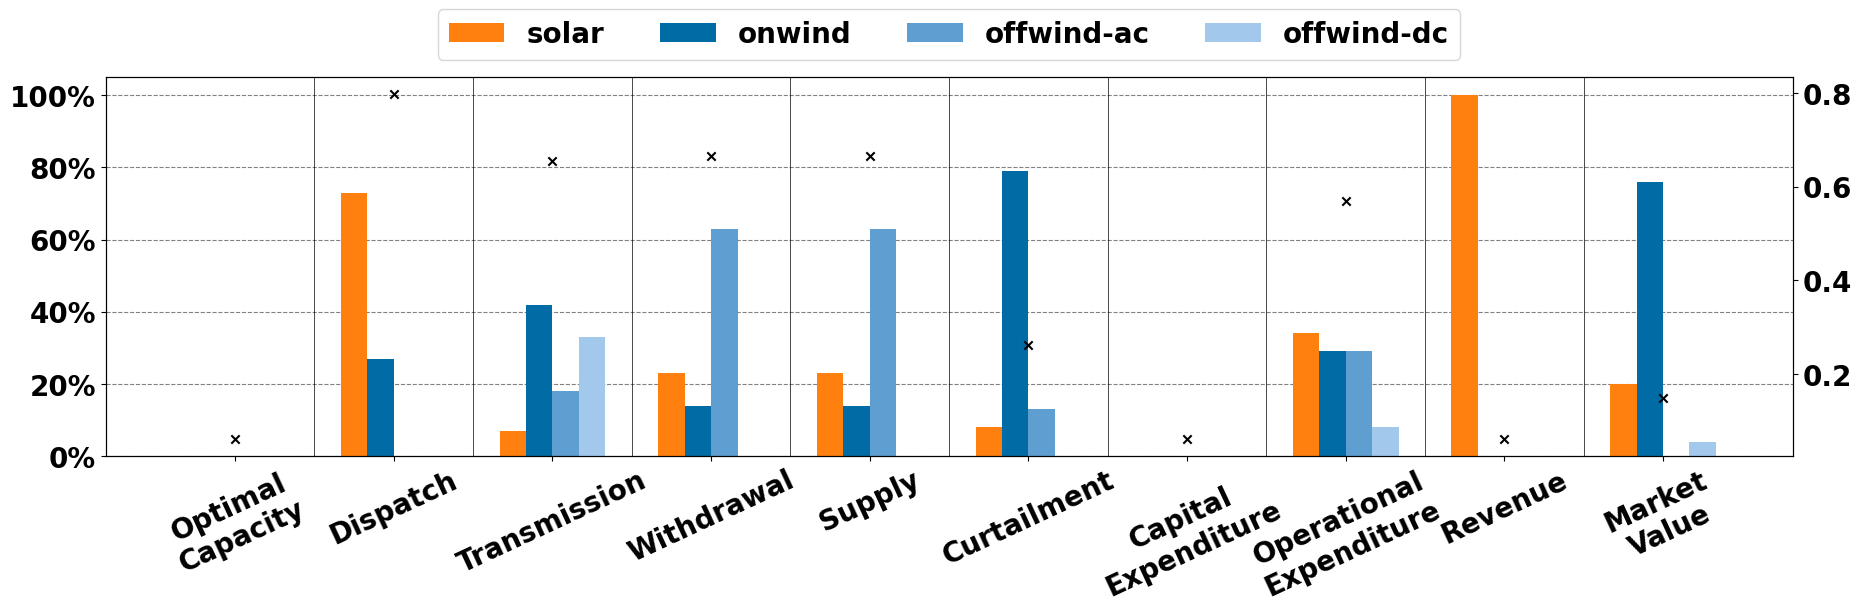

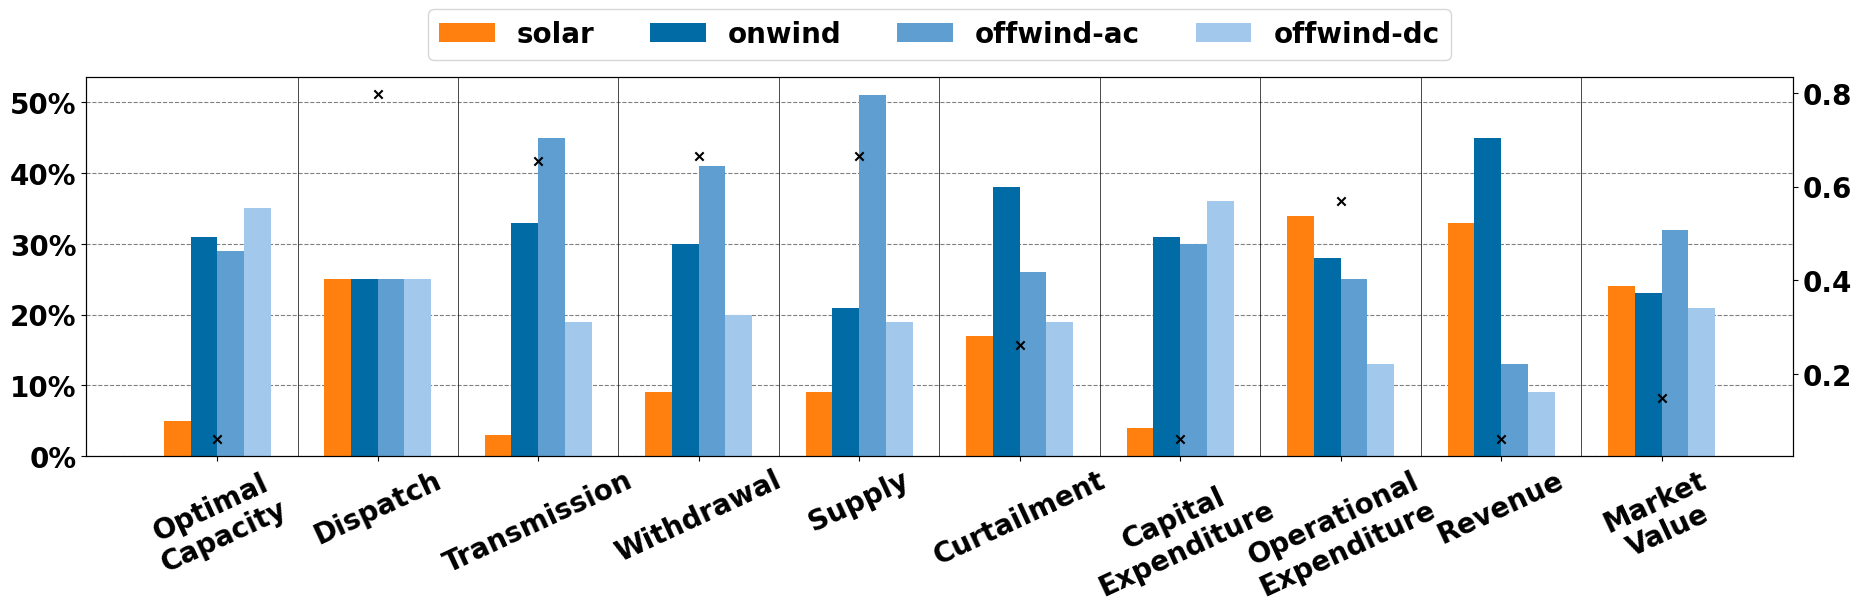

In [8]:
simple_experiment.plot_features('1w')
simple_experiment.plot_results('1w')

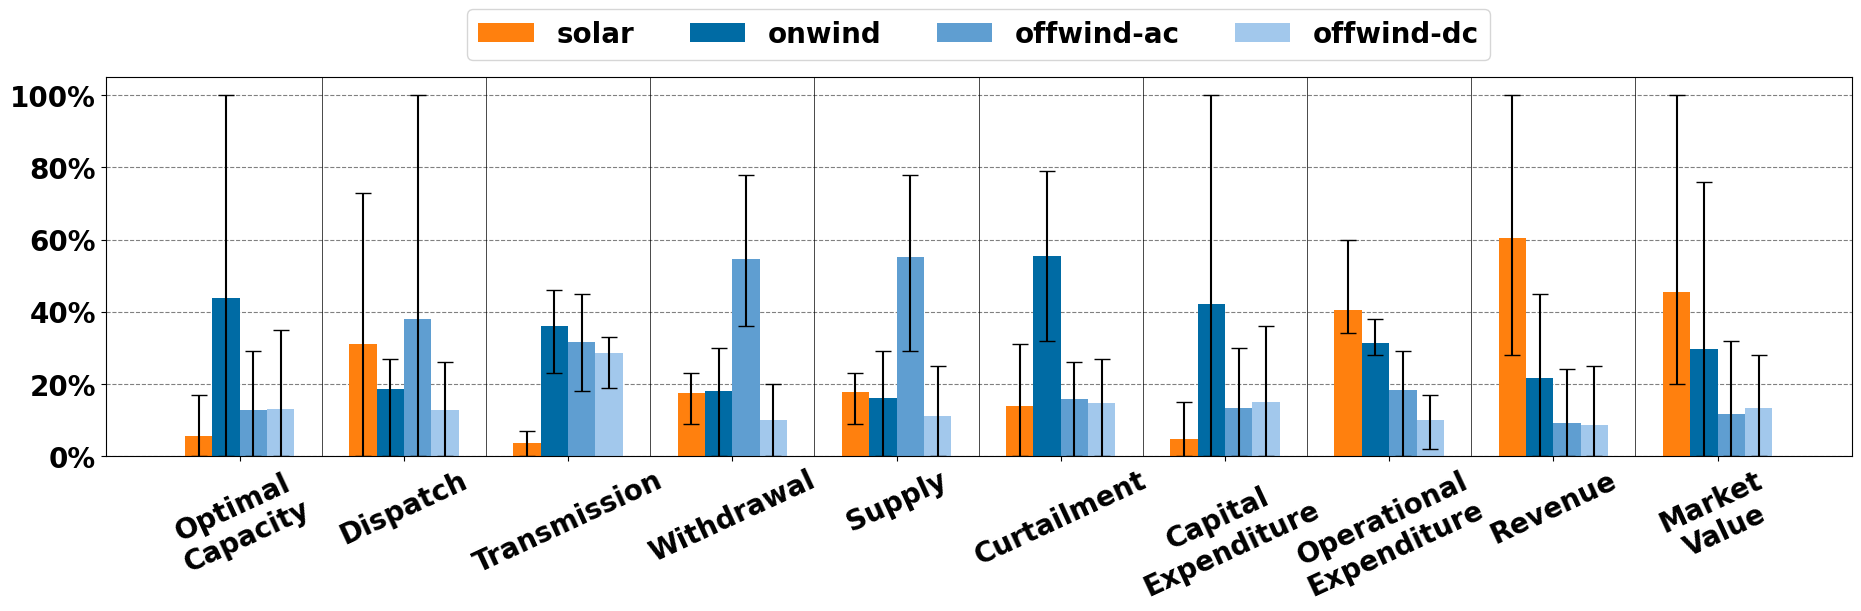

In [9]:
simple_experiment.plot_all_results()

## generators and location

In [10]:
generators = ['solar', 'wind']
location_split_x = 10
location_split_y = 51

def get_location_features(netw: pypsa.Network):
    feature_data = netw.generators_t.p_max_pu
    feature_array = []
    for generator in generators:
        df_generator = feature_data.filter(like=generator, axis=1)
        location_array = [[], [], [], []]
        for column in df_generator:
            bus = column.rpartition(' ')[0]
            if netw.buses['y'][bus] > location_split_y:
                if netw.buses['x'][bus] <= location_split_x:
                    location_array[0].append(np.mean(df_generator[column]))
                else:
                    location_array[1].append(np.mean(df_generator[column]))
            else: 
                if netw.buses['x'][bus] <= location_split_x:
                    location_array[2].append(np.mean(df_generator[column]))
                else:
                    location_array[3].append(np.mean(df_generator[column]))
        for a in location_array:
            if len(a) == 0:
                feature_array.append(0)
            else: 
                feature_array.append(np.mean(a))
    return feature_array

In [11]:
location_feature_names = [g+' ' + y+x for g in ['solar', 'wind'] for y in ['north', 'south'] for x in ['west', 'east']]
feature_colors = [colors['orange'+str(i+1)] for i in range(4)] + [colors['blue'+str(i+1)] for i in range(4)]

location_experiment = Experiment('location', netw_splits, result_vectors)
location_experiment.create_features(get_location_features, location_feature_names, feature_colors)
location_experiment.run_algorithms()

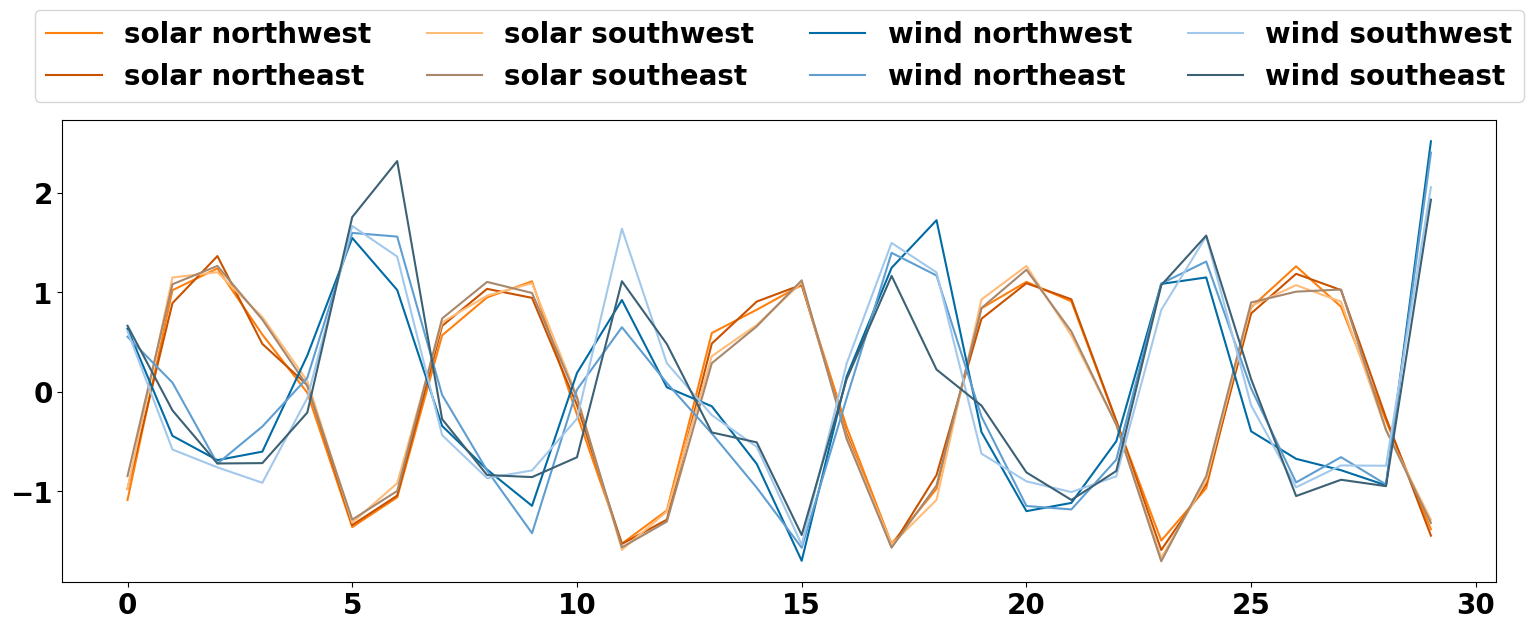

In [12]:
location_experiment.plot_features('2m')

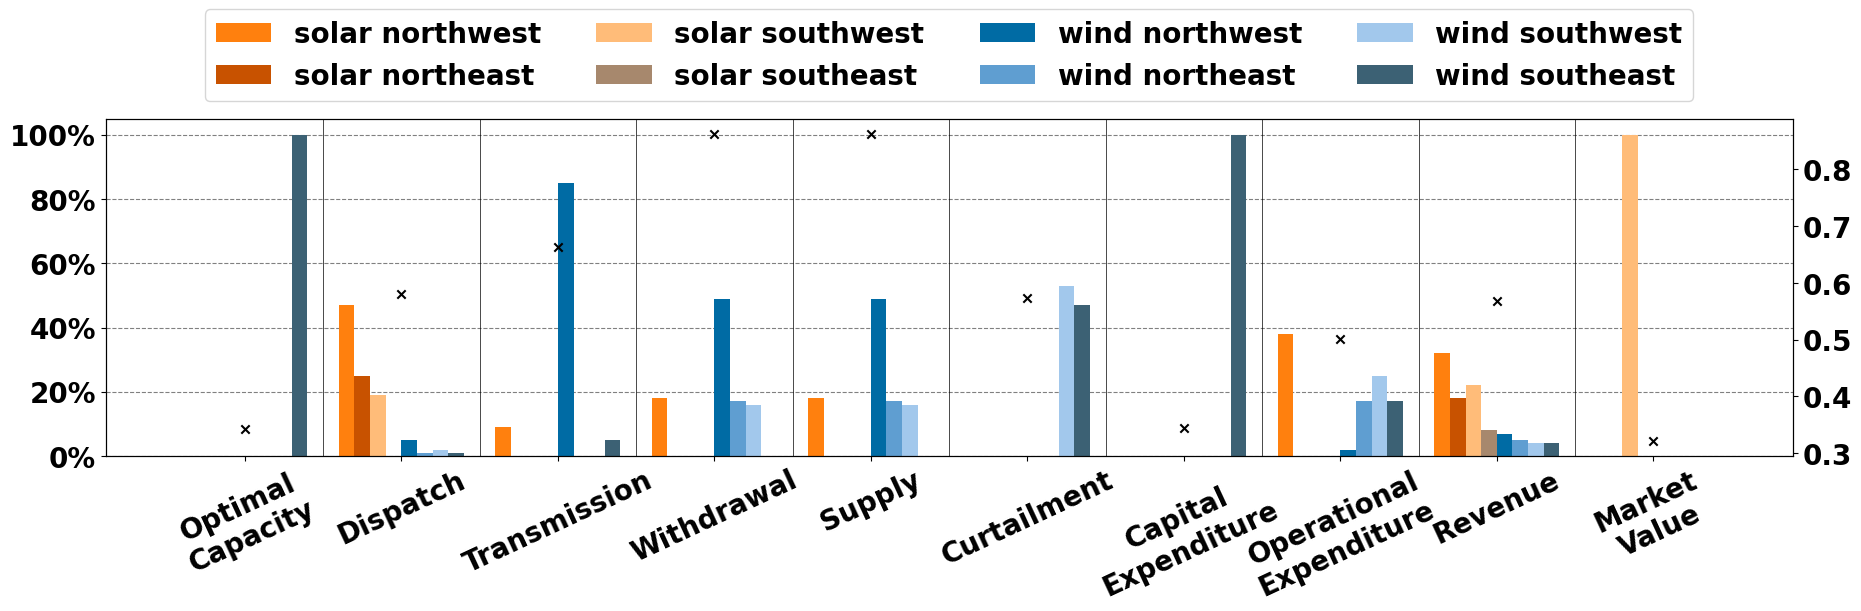

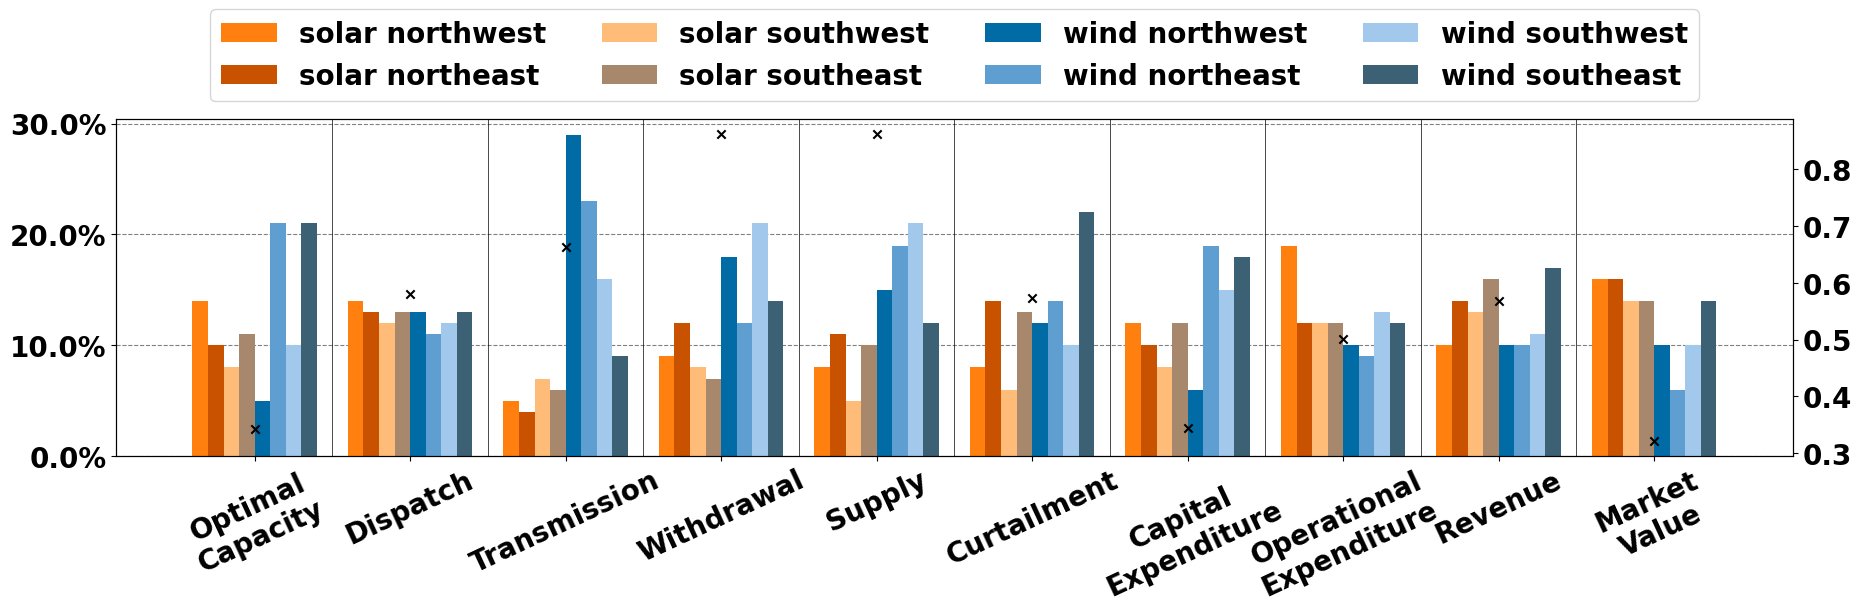

In [13]:
location_experiment.plot_results('2m')

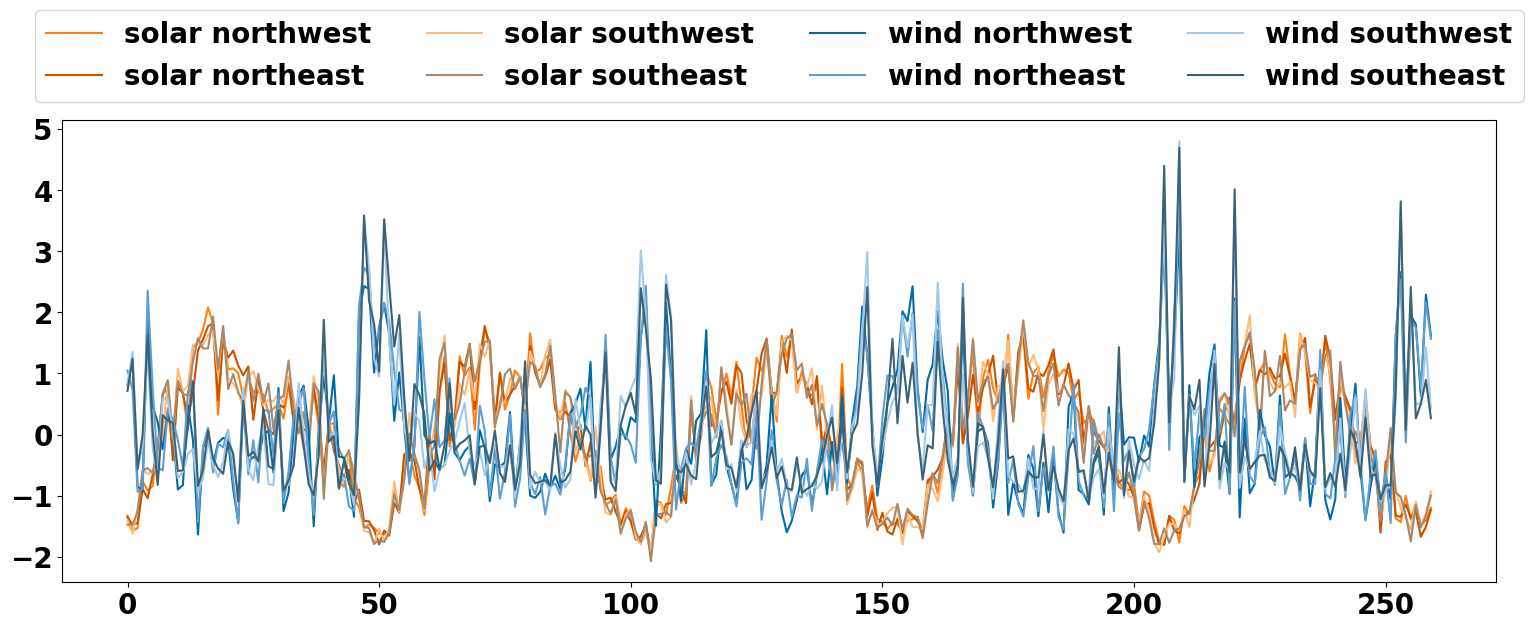

In [14]:
location_experiment.plot_features('1w')

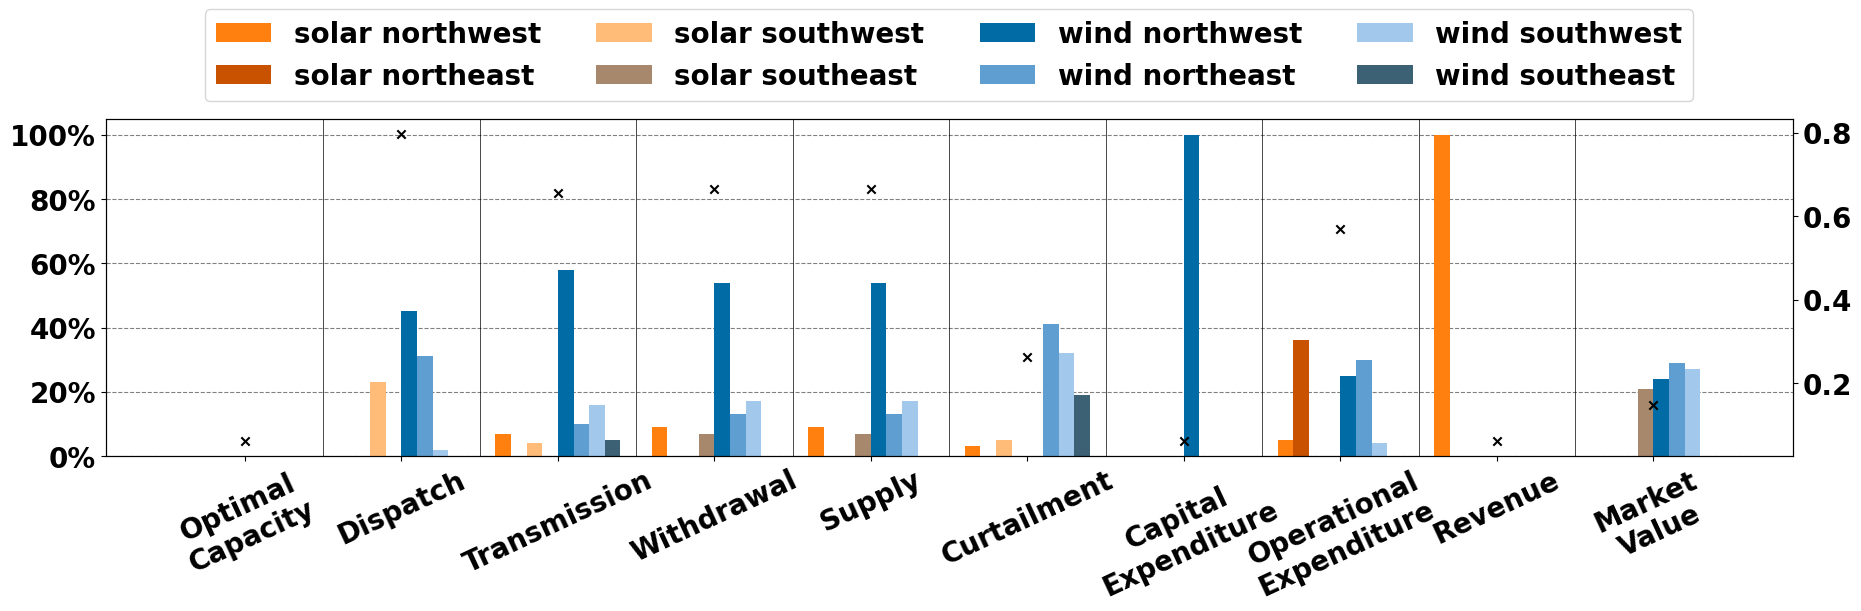

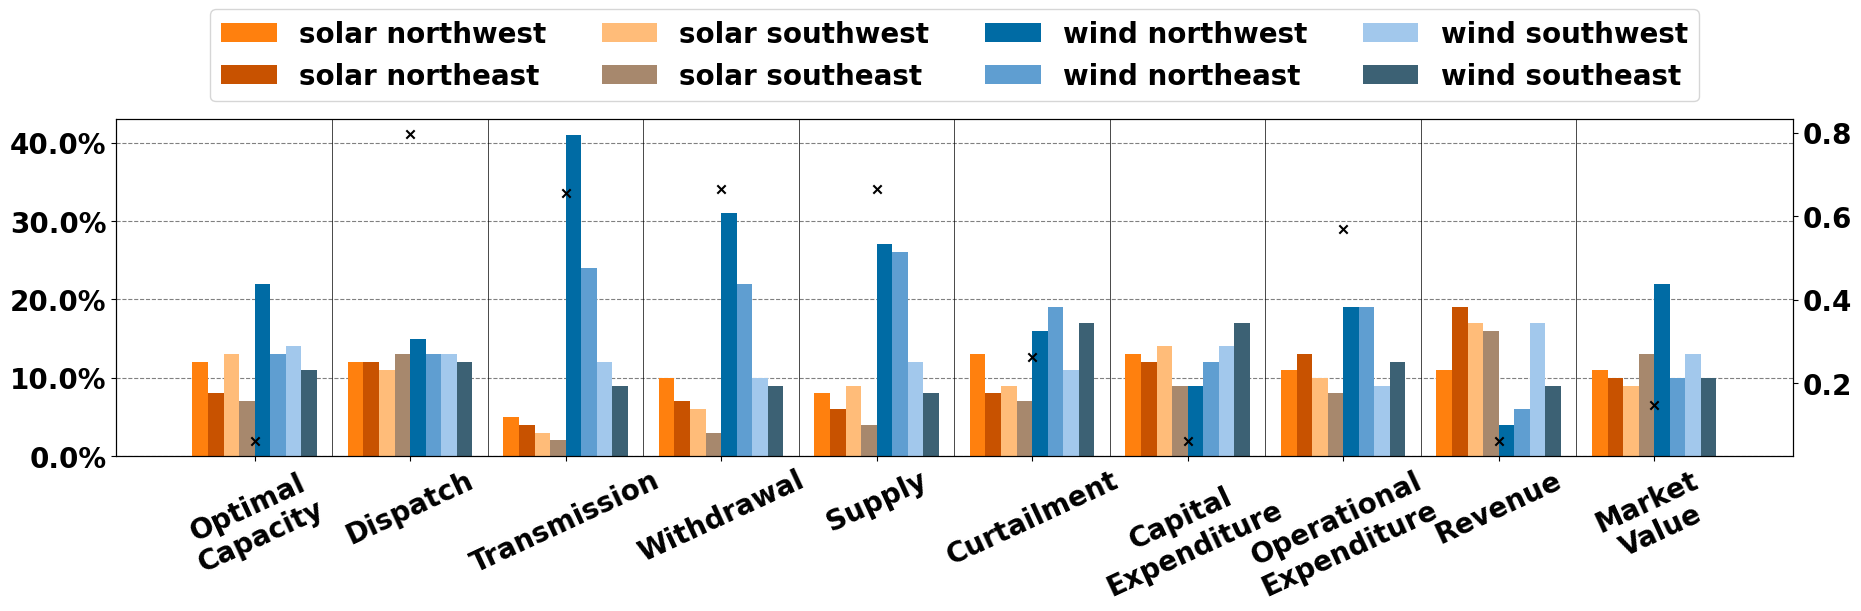

In [15]:
location_experiment.plot_results('1w')

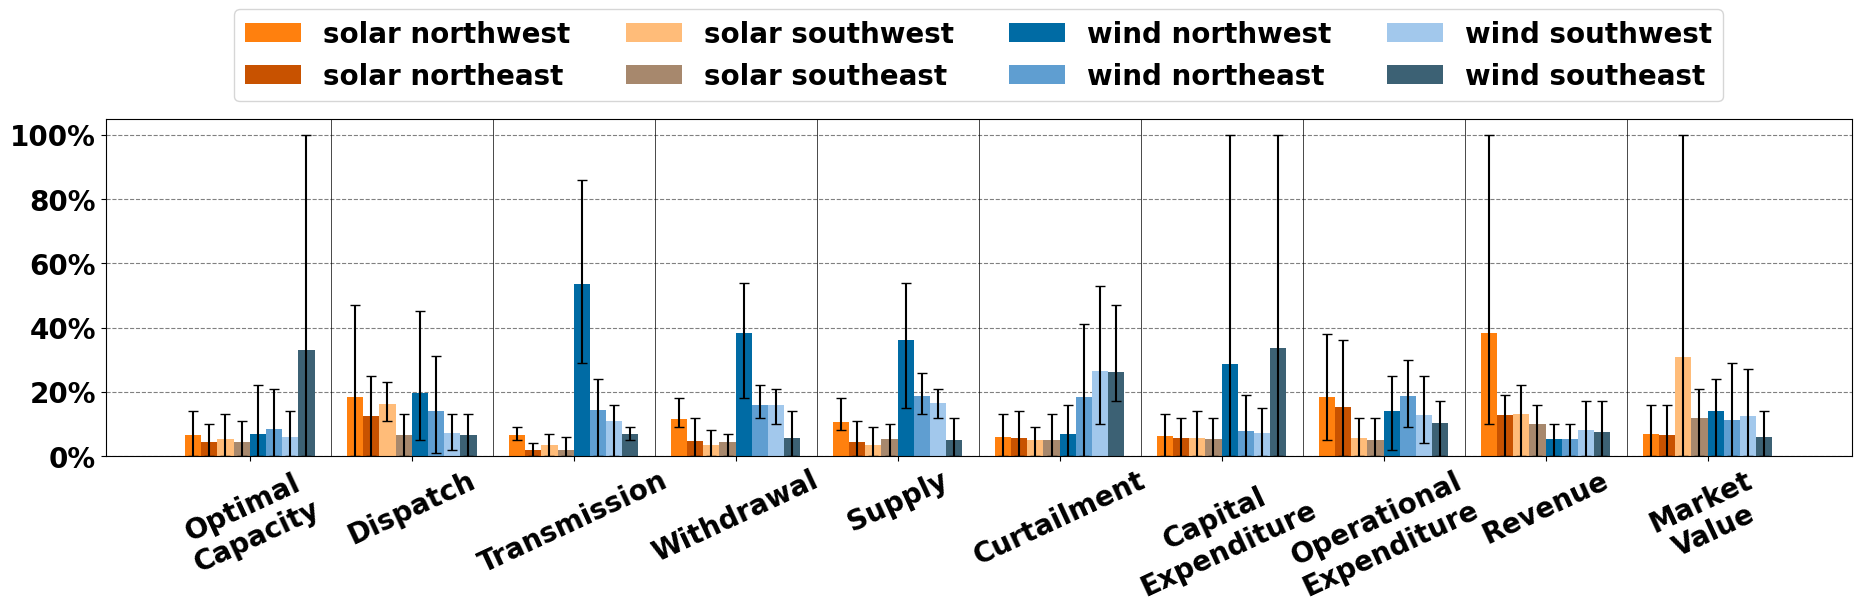

In [16]:
location_experiment.plot_all_results()

## weather data

In [18]:
def get_weather_feature_array(filename: str, feature_keys=None):
    with open(filename, 'rb') as f:
        weather_features = pickle.load(f)
    if feature_keys is None:
        feature_keys = ['wnd100m', 'wnd_azimuth', 'roughness', 'influx_toa', 'influx_direct', 'influx_diffuse', 'albedo', 'solar_altitude', 'solar_azimuth', 'temperature', 'soil temperature', 'runoff']

    feature_array = np.array([weather_features[key] for key in feature_keys]).T
    feature_scaler = StandardScaler().fit(feature_array)
    feature_array = feature_scaler.transform(feature_array)
    return feature_array

In [ ]:
print(weather_features.keys())

### 2 month - all

In [ ]:
feature_keys = ['wnd100m', 'wnd_azimuth', 'roughness', 'influx_toa', 'influx_direct', 'influx_diffuse', 'albedo', 'solar_altitude', 'solar_azimuth', 'temperature', 'soil temperature', 'runoff']

feature_array = get_weather_feature_array('weather_features.pkl')
plot_feature_array(feature_array, 'weather_2m_all_features', feature_keys)

In [ ]:
coefficients, weights, MADs = run_algorithms(netw_split_2m, feature_array)

plot_results(coefficients, feature_keys, MADs=MADs, title='weather_2m_all_Lasso')
plot_results(weights, feature_keys, MADs=MADs, title='weather_2m_all_Random_Forest')

### 2 month - wind,influx,tempr

In [25]:
feature_names = ['wnd100m','influx_direct', 'influx_diffuse', 'temperature']
feature_colors = [colors['blue1'], colors['orange1'], colors['orange2'], colors['grey2']]
feature_matrix_2m = get_weather_feature_array('weather_features.pkl', feature_names)
feature_matrix_1w = get_weather_feature_array('weather_features_1w.pkl', feature_names)
feature_matrices = {'2m': feature_matrix_2m, '1w': feature_matrix_1w}

weather_experiment = Experiment('weather_wind,influx,tempr', netw_splits, result_vectors, feature_matrices, feature_names, feature_colors)
weather_experiment.run_algorithms()

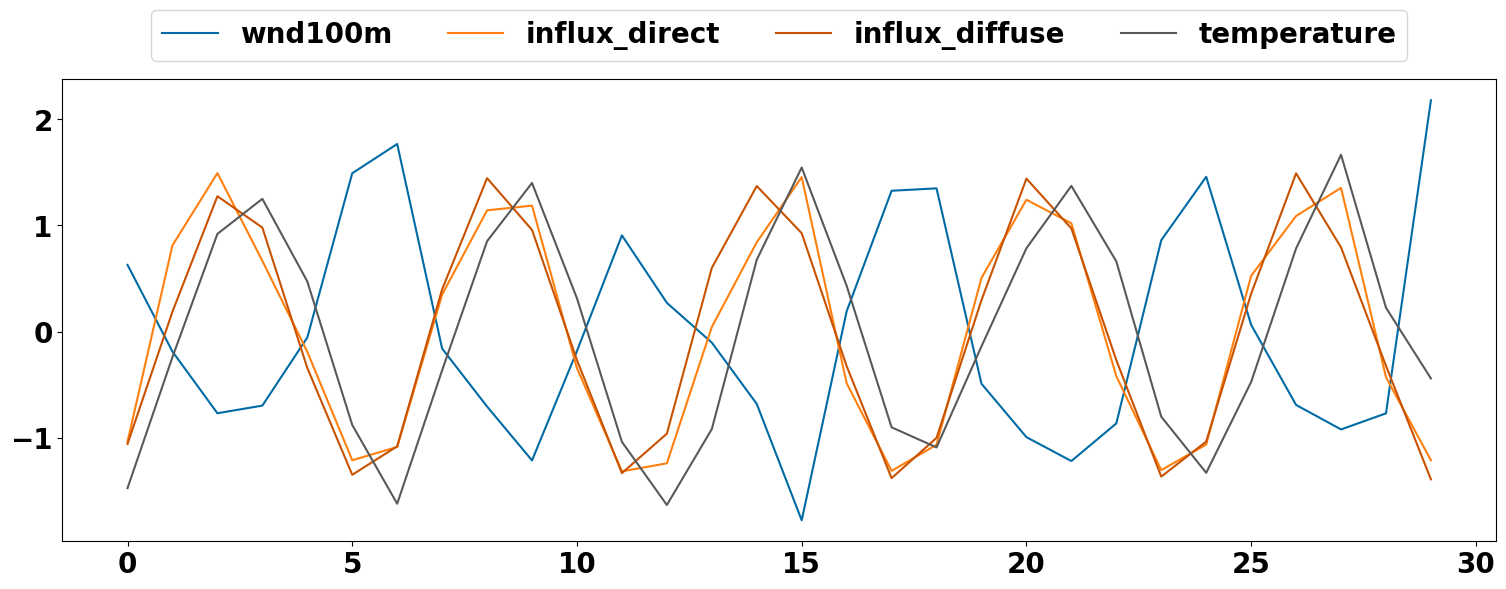

In [26]:
weather_experiment.plot_features('2m')

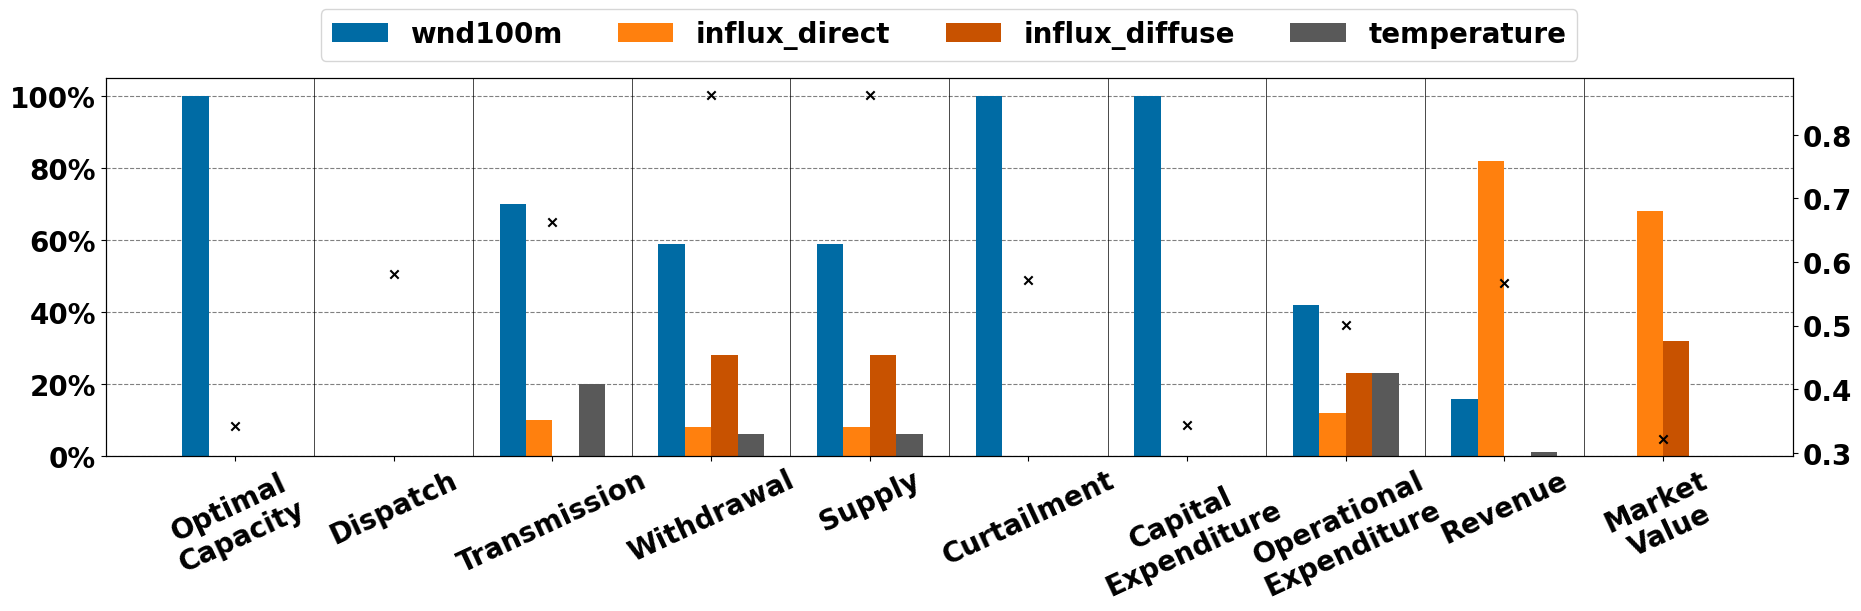

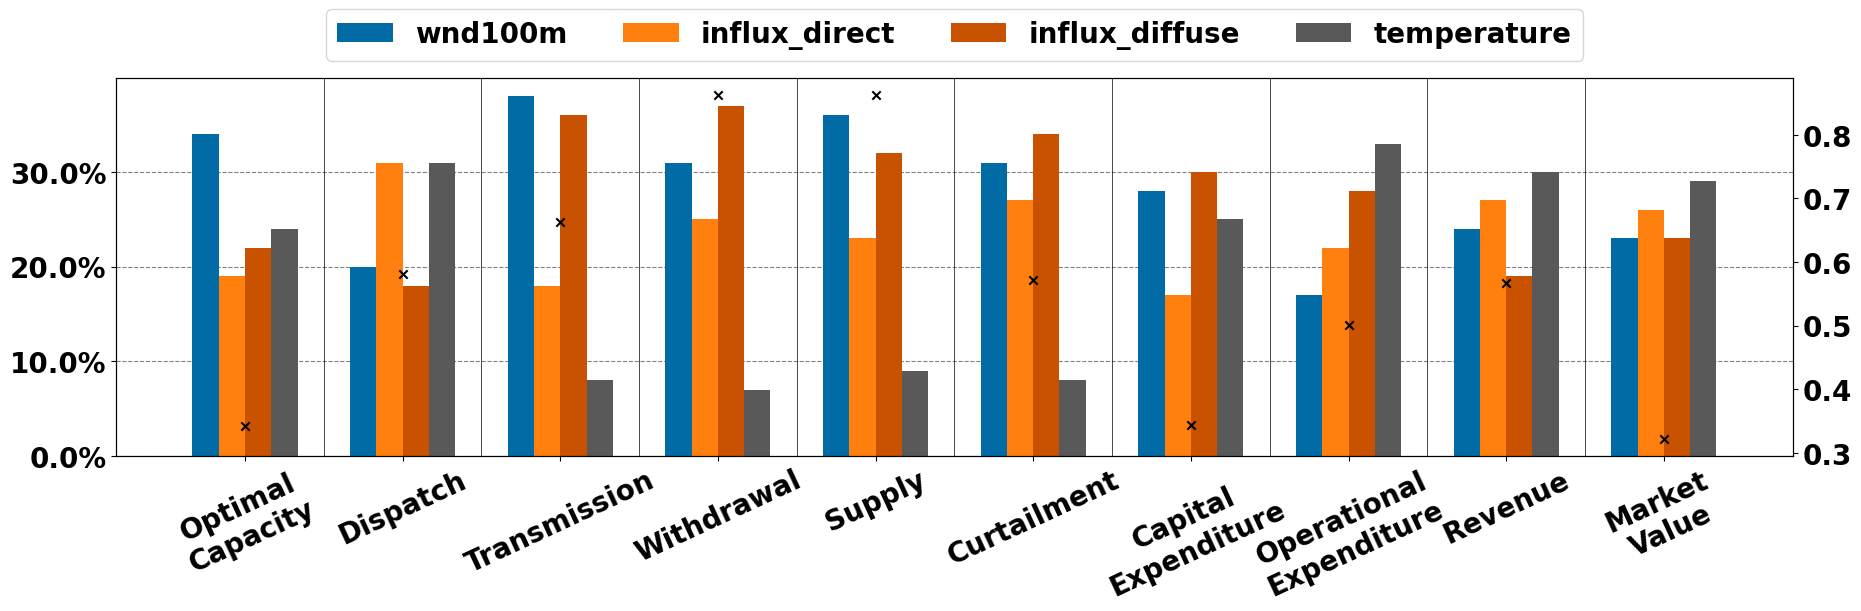

In [27]:
weather_experiment.plot_results('2m')

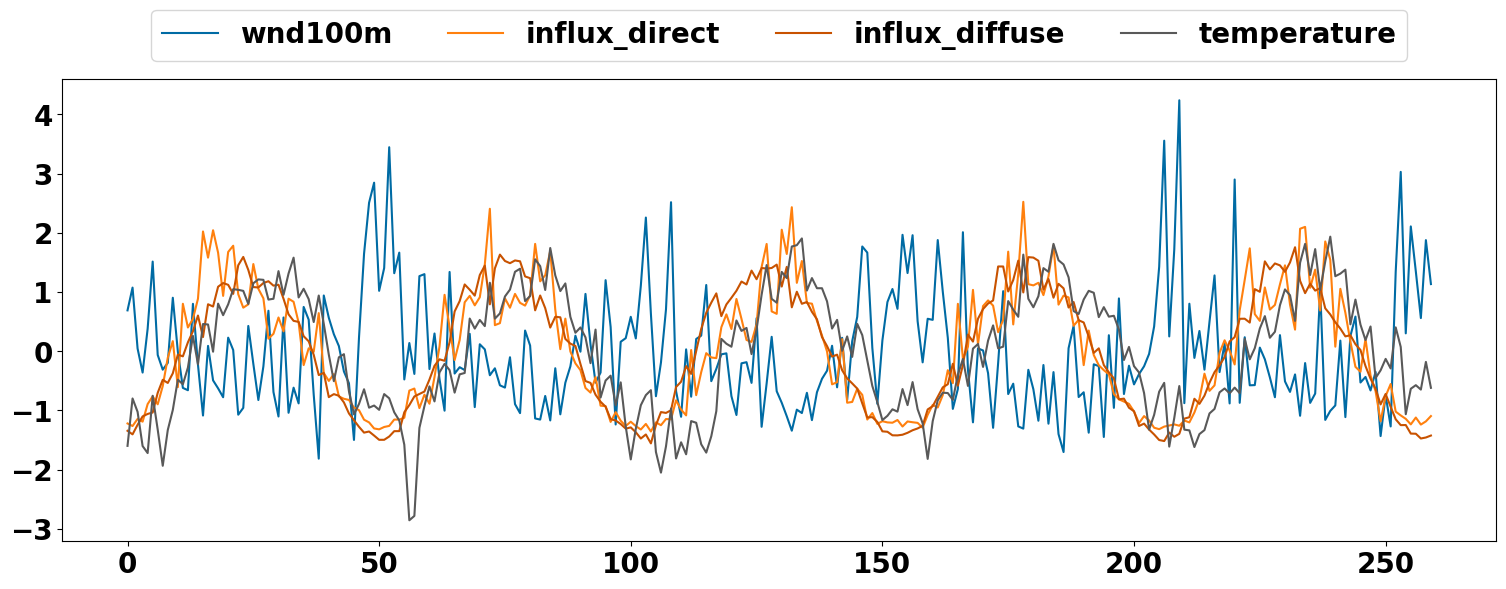

In [28]:
weather_experiment.plot_features('1w')

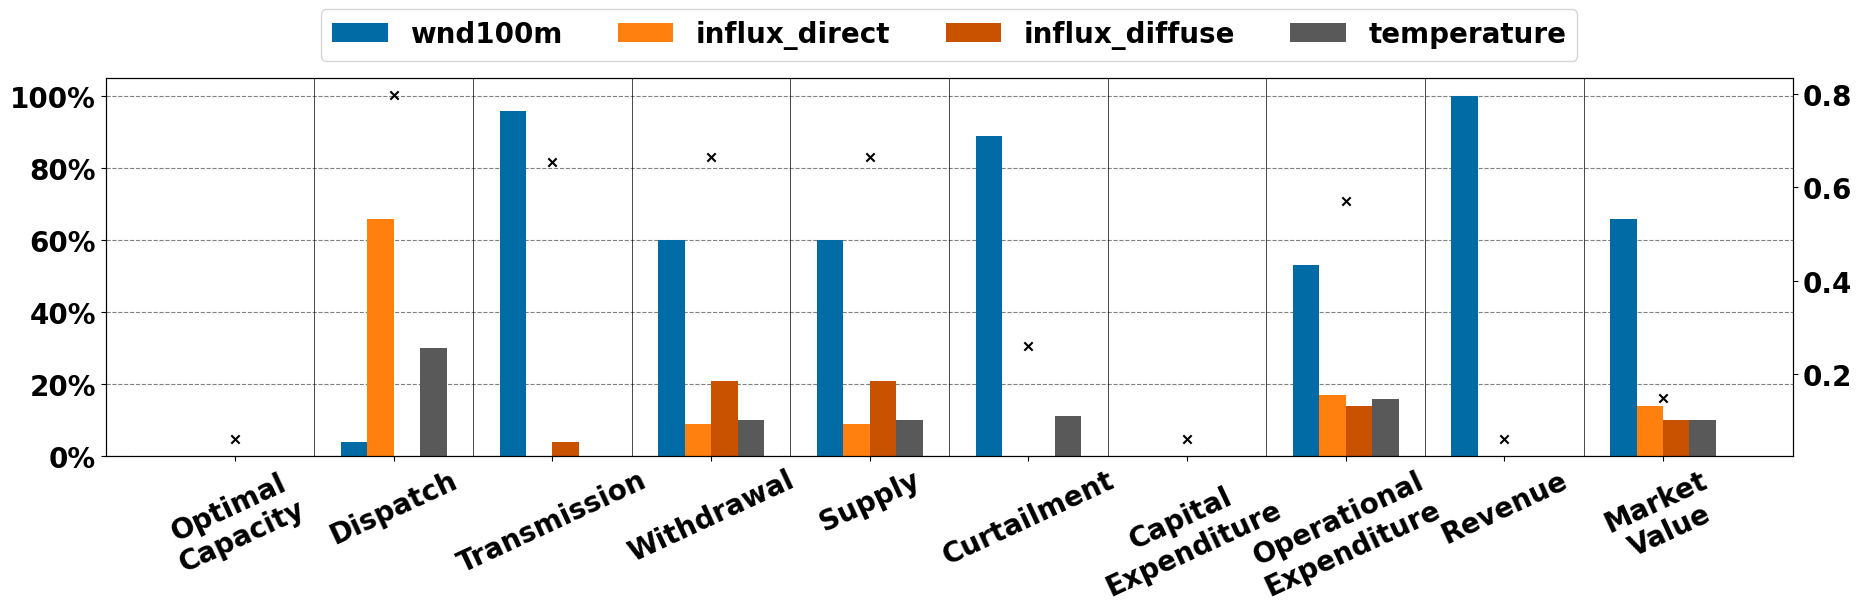

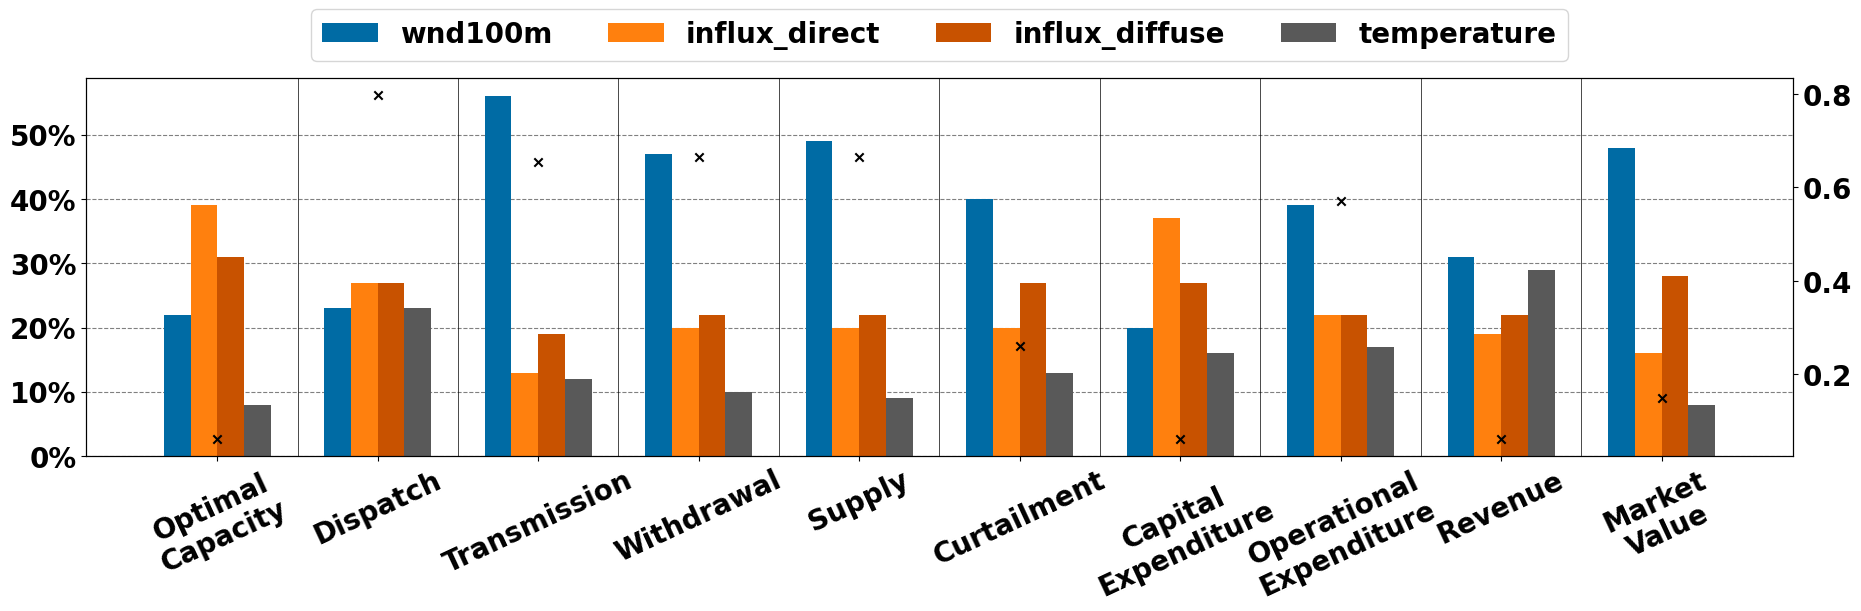

In [29]:
weather_experiment.plot_results('1w')

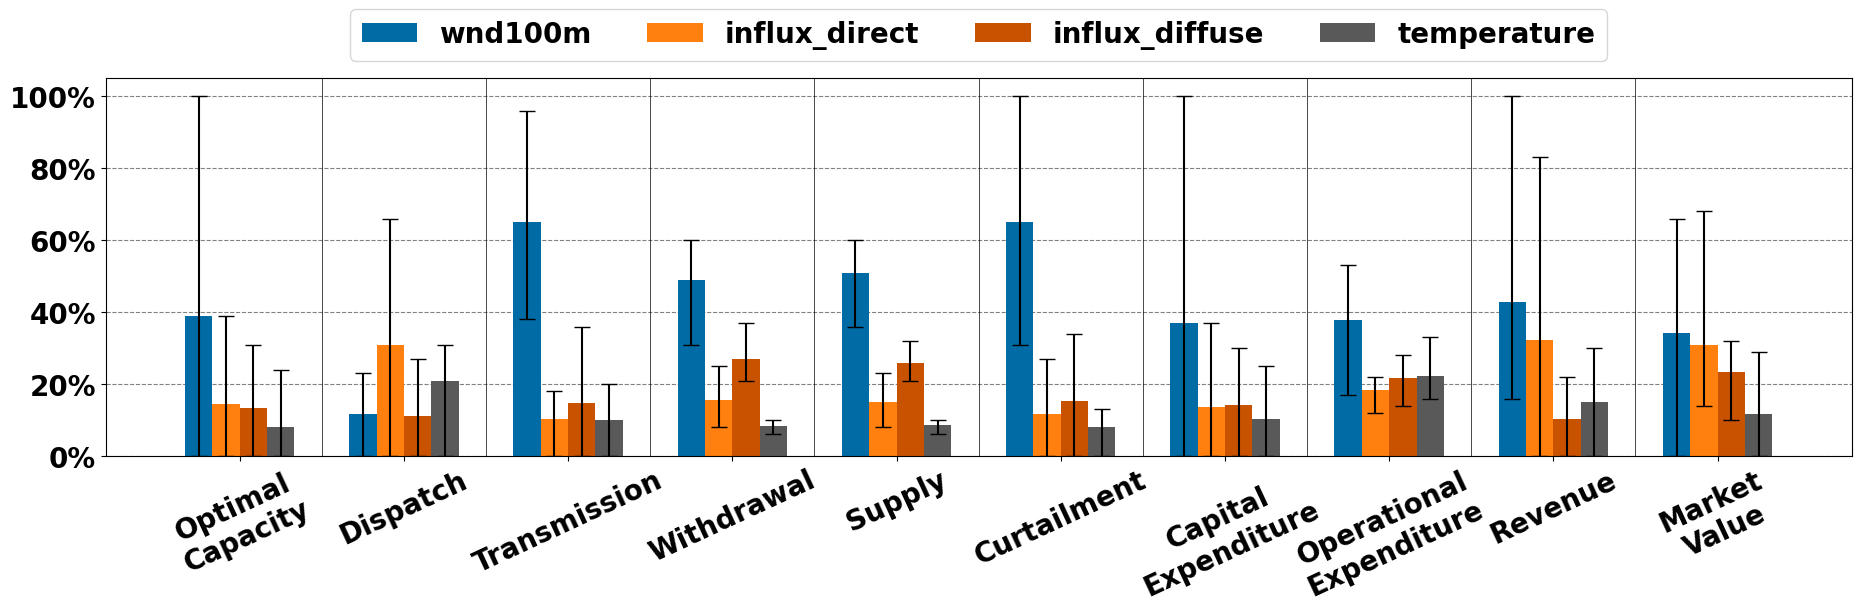

In [30]:
weather_experiment.plot_all_results()

### 2 month - wind,influx,solAltitude,runoff

In [ ]:
feature_keys = ['wnd100m', 'influx_direct', 'solar_altitude', 'runoff']

feature_array = get_weather_feature_array('weather_features.pkl', feature_keys)
plot_feature_array(feature_array, 'weather_2m_wind,influx,solAltitude,runoff_features', feature_keys)

In [ ]:
coefficients, weights, MADs = run_algorithms(netw_split_2m, feature_array)

plot_results(coefficients, feature_keys, MADs=MADs, title='weather_2m_wind,influx,solAltitude,runoff_Lasso')
plot_results(weights, feature_keys, MADs=MADs, title='weather_2m_wind,influx,solAltitude,runoff_Random_Forest')

### 1 week - all

In [ ]:
feature_keys = ['wnd100m', 'wnd_azimuth', 'roughness', 'influx_toa', 'influx_direct', 'influx_diffuse', 'albedo', 'solar_altitude', 'solar_azimuth', 'temperature', 'soil temperature', 'runoff']

feature_array = get_weather_feature_array('weather_features_1w.pkl')
plot_feature_array(feature_array, 'weather_1w_all_features', feature_keys)

In [ ]:
coefficients, weights, MADs = run_algorithms(netw_split_1w, feature_array)

plot_results(coefficients, feature_keys, MADs=MADs, title='weather_1w_all_Lasso')
plot_results(weights, feature_keys, MADs=MADs, title='weather_1w_all_Random_Forest')

### 1 week - wind location

In [ ]:
def import_wind_features(file_name):
    with open(f'{file_name}.pkl', 'rb') as f:
        features = pickle.load(f)
    names = list(features.keys())
    matrix = np.array([features[key] for key in names]).T
    scaler = StandardScaler().fit(matrix)
    matrix = scaler.transform(matrix)
    return names, matrix

feature_names, feature_matrix_2m = import_wind_features('weather_features_wind_2m')
feature_names, feature_matrix_1w = import_wind_features('weather_features_wind_1w')
feature_matrices = {'2m': feature_matrix_2m, '1w': feature_matrix_1w}

wind_experiment = Experiment('weather_wind', netw_splits, result_vectors, feature_matrices, feature_names)
wind_experiment.run_algorithms()

In [ ]:
wind_experiment.plot_features('2m')

In [ ]:
wind_experiment.plot_results('2m')

In [ ]:
wind_experiment.plot_features('1w')

In [ ]:
wind_experiment.plot_results('1w')

In [ ]:
wind_experiment.plot_all_results()

## time

In [31]:
def get_month_feature(netw: pypsa.Network):
    date = netw.snapshots[int(len(netw.snapshots)/2)]
    features = np.zeros(6)
    features[int((date.month-1)/2)] = 1
    return features

In [32]:
time_experiment = Experiment('time', netw_splits, result_vectors)

feature_names=['Jan/Feb', 'Mar/Apr', 'May/Jun', 'Jul/Aug', 'Sep/Oct', 'Nov/Dec']
feature_colors=[colors['blue2'], colors['grey1'], colors['orange1'], colors['orange2'], colors['grey2'], colors['blue1']]
time_experiment.create_features(get_month_feature, feature_names, feature_colors)
time_experiment.run_algorithms()

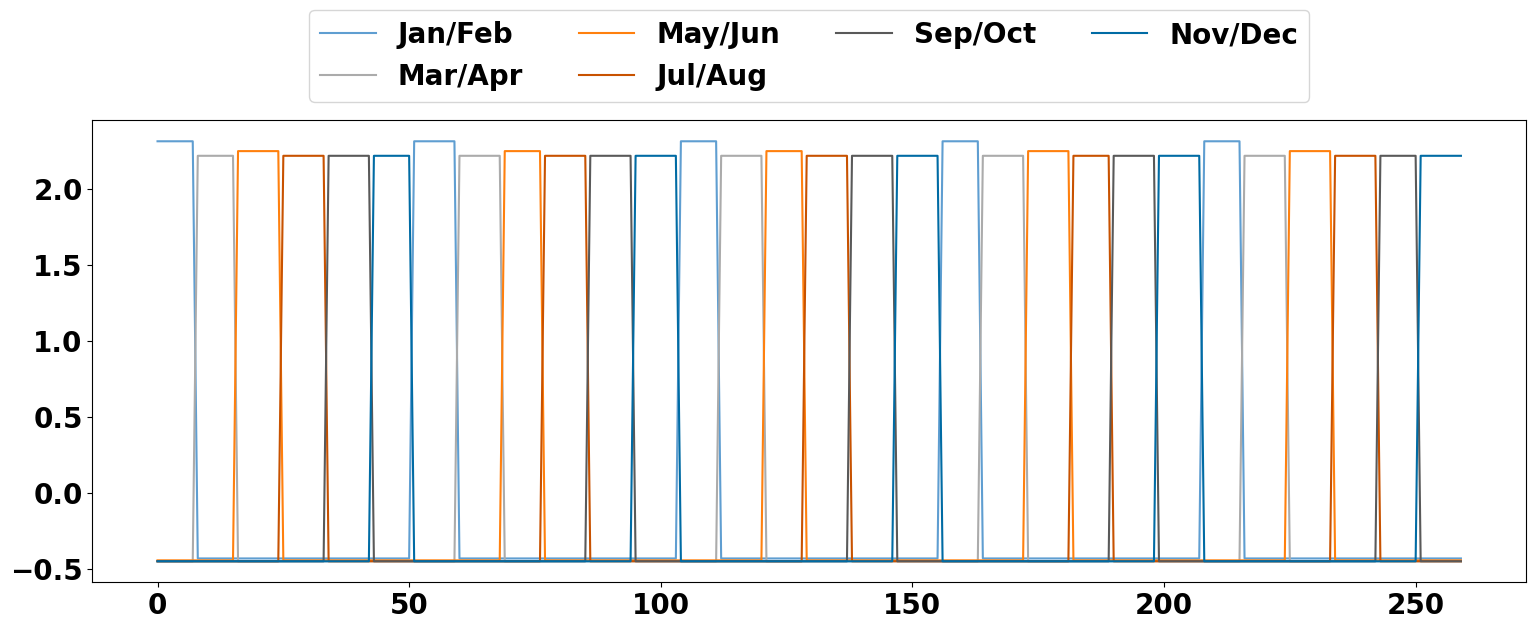

In [33]:
time_experiment.plot_features('1w')

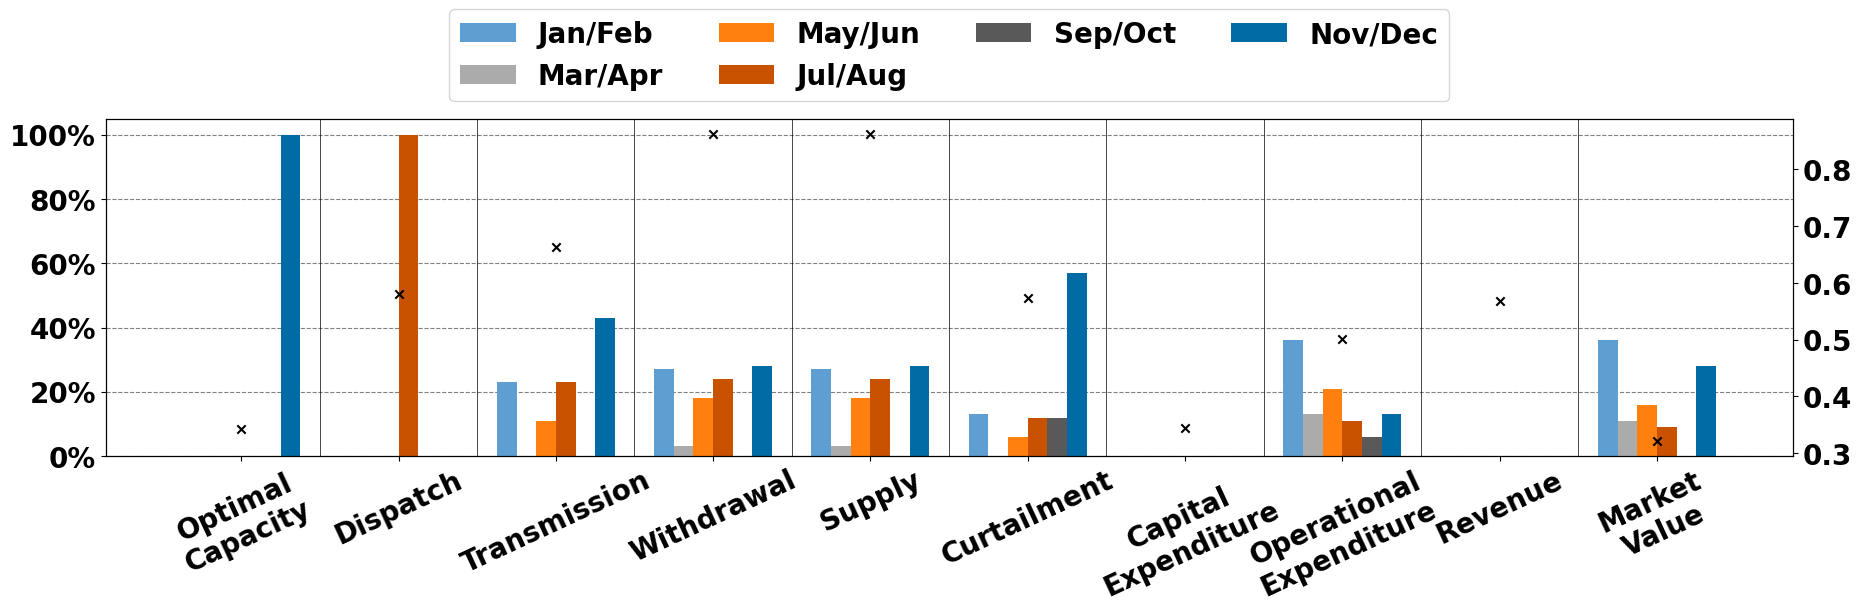

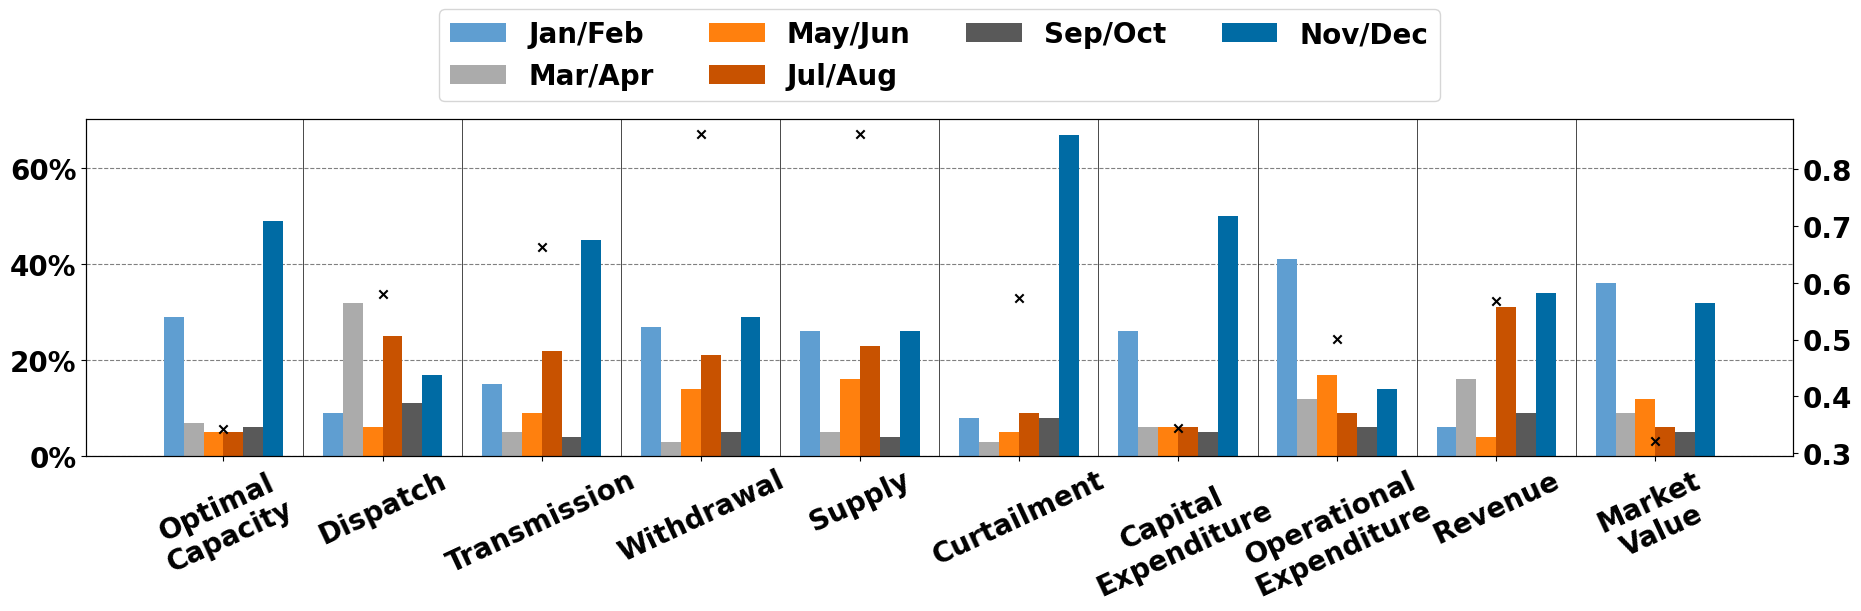

In [34]:
time_experiment.plot_results('2m')

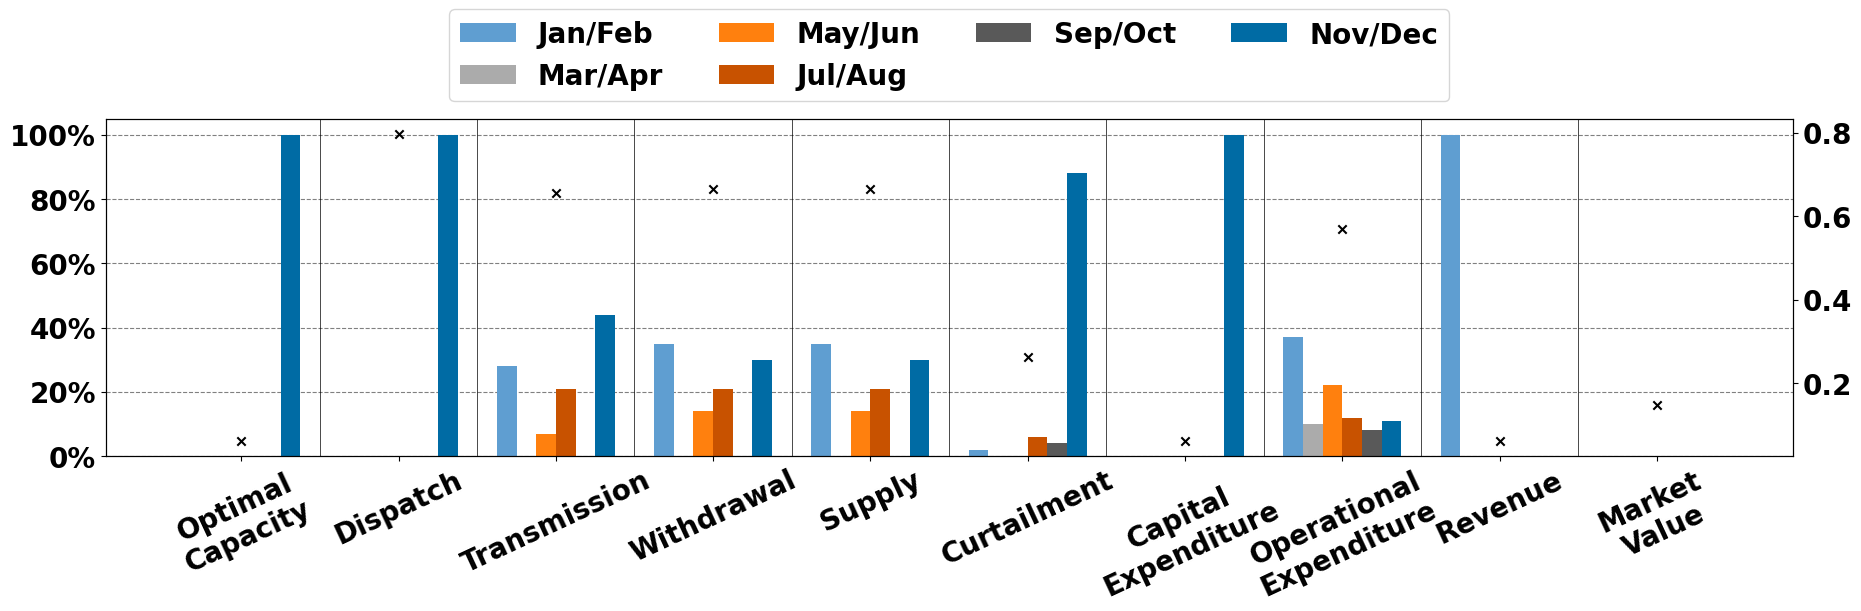

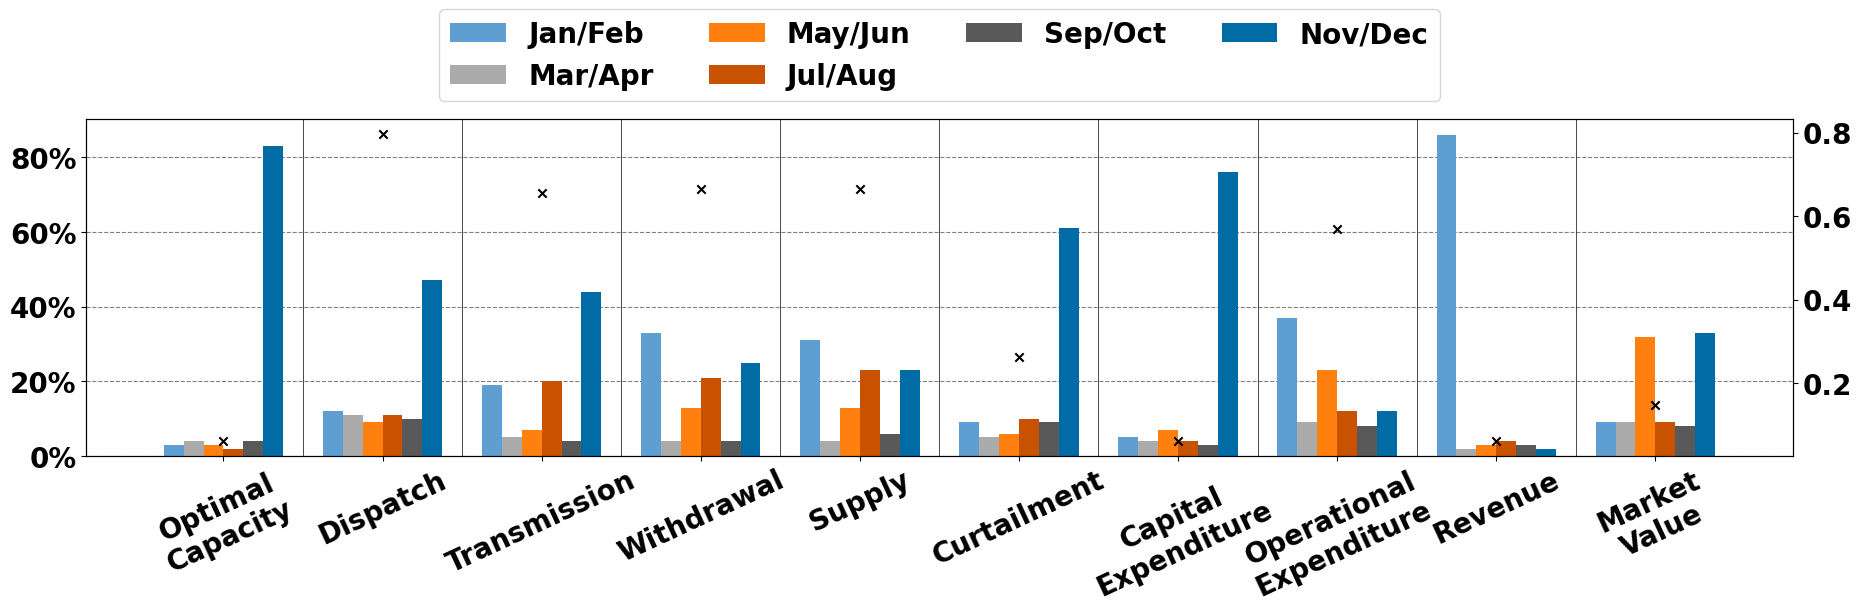

In [35]:
time_experiment.plot_results('1w')

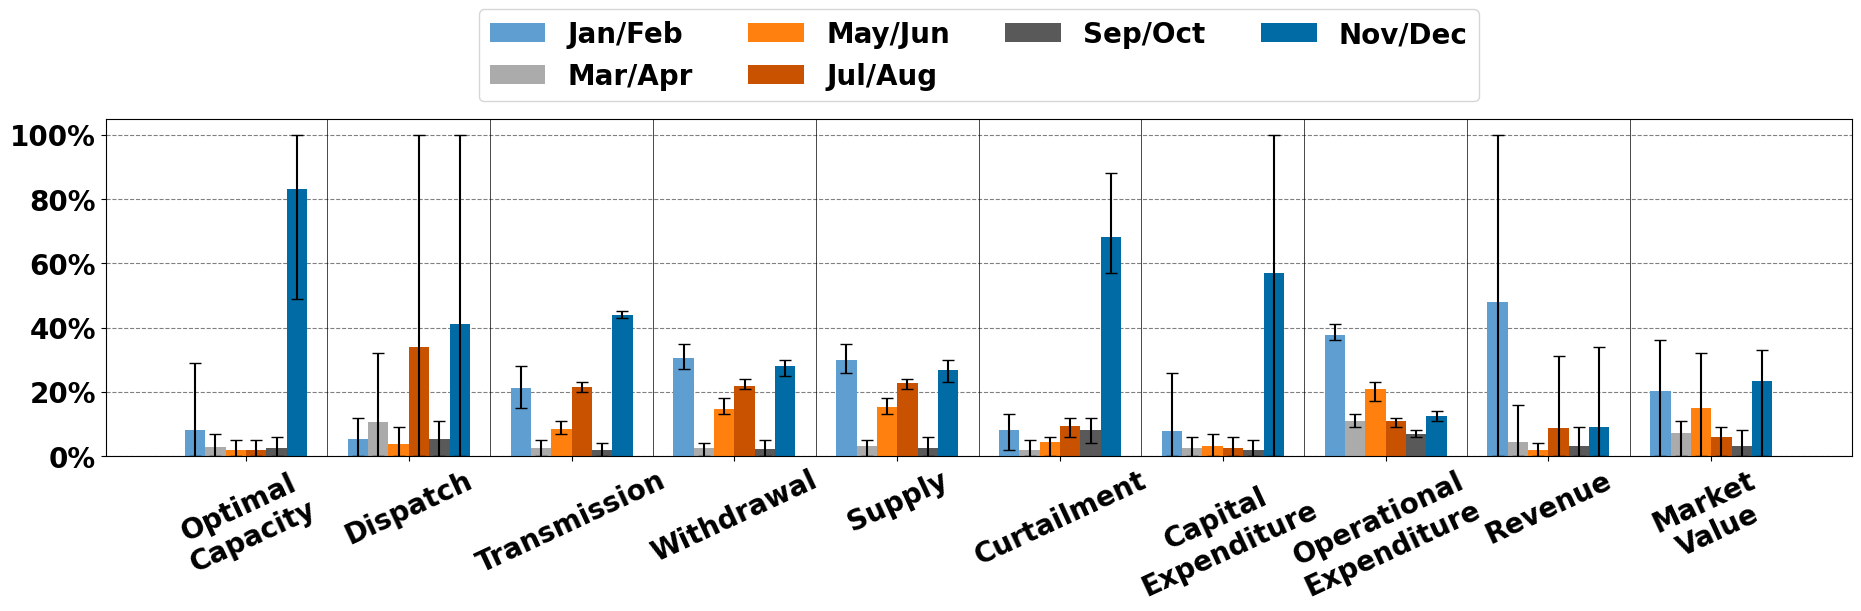

In [36]:
time_experiment.plot_all_results()

# Create Delete buses

In [ ]:
buses = []
longitude = [] # x
latitude = [] # y
for i, bus in n.buses.iterrows():
    if 'H2' in bus.name:
        continue
    buses.append(bus.name)
    longitude.append(bus['x'])
    latitude.append(bus['y'])

print(buses)
print(longitude)
print(latitude)

longitude_sorted = np.argsort(longitude)
latitude_sorted = np.argsort(latitude)

In [ ]:
def find_connections(links: pd.DataFrame, key):
    res = []
    for _, link in links.iterrows():
        if (key + ' ' in link['bus0']) or (key == link['bus0']) or (key + ' ' in link['bus1']) or (key == link['bus1']):
            res.append(link.name)
    return res

def find_components(components: pd.DataFrame, key, colum='bus'):
    res = []
    for _, component in components.iterrows():
        if (key + ' ' in component[colum]) or (key == component[colum]):
            res.append(component.name)
    return res

def flatten(list):
    flat_list = []
    for row in list:
        flat_list.extend(row)
    return flat_list

def find_all_classes(keyword_split):
    buses_split = keyword_split + [key + ' H2' for key in keyword_split]
    generators_split = flatten([find_components(n.generators, key) for key in keyword_split])
    links_split = flatten([find_connections(n.links, key) for key in keyword_split])
    lines_split = flatten([find_connections(n.lines, key) for key in keyword_split])
    stores_split = flatten([find_components(n.stores, key) for key in keyword_split])
    storage_unit_split = flatten([find_components(n.storage_units, key) for key in keyword_split])
    load_split = flatten([find_components(n.loads, key) for key in keyword_split])
    shapes_split = flatten([find_components(n.shapes, key, 'idx') for key in keyword_split])

    return [('Bus', buses_split), 
            ('Generator', generators_split), 
            ('Link', links_split), 
            ('Store', stores_split), 
            ('StorageUnit', storage_unit_split), 
            ('Load', load_split), 
            ('Shape', shapes_split),
            ('Line', lines_split)]

def remove_busses(netw, keywords):
    classes = find_all_classes(keywords)
    netw_copy = netw.copy()
    for c, split in classes:
        netw_copy.mremove(c, split)
    return netw_copy


In [ ]:
data_split = []

splits = [(2, 2), (2, 3), (3, 3), (2, 4)]

for x, y in splits:
    for latitude_split in split_list(latitude_sorted, y) :
        for longitude_split in split_list(longitude_sorted, x):
            keyword_split = [buses[i] for i in longitude_split if i in latitude_split]
            data_split.append(remove_busses(n, keyword_split))

In [ ]:
len(data_split)

In [ ]:
data_split[1].optimize(solver_name="gurobi")

In [ ]:
data_split[1].export_to_netcdf(path=f'data_split/{1}.nc')

In [ ]:
directory = os.fsencode('data_split')
data_split = [pypsa.Network(f'data_split/{os.fsdecode(file)}') for file in os.listdir(directory)]

# Simple on del. netw

In [ ]:
for netw in data_split:
    netw.plot()
    plt.show()

# Optimization by time

In [ ]:
directory = os.fsencode('data_split')
data_split = [pypsa.Network(f'data_split/{os.fsdecode(file)}') for file in os.listdir(directory)]

In [ ]:
feature_array = []
generator_keys = ['solar', 'wind']

for netw in data_split:
    sample = []
    df = netw.generators_t.p_max_pu
    for key in generator_keys:
        month_data = [[] for _ in range(4)]
        filtered_df = df.filter(like=key, axis=1)
        for index, row in filtered_df.iterrows():
            month_data[(index.month-1) % 4].append(np.mean(row))
        sample += [np.mean(month) for month in month_data]
    feature_array.append(sample)

feature_scaler = StandardScaler().fit(feature_array)
feature_array = feature_scaler.transform(feature_array)

plot_feature_array(feature_array)

In [ ]:
feature_array2 = []

for netw in data_split:
    df = netw.generators_t.p_max_pu
    month_data = [[] for _ in range(6)]
    filtered_df = df.filter(like=key, axis=1)
    for index, row in filtered_df.iterrows():
        month_data[(index.month-1) % 6].append(np.mean(row))
    sample = [np.mean(month) for month in month_data]
    feature_array2.append(sample)

feature_scaler = StandardScaler().fit(feature_array2)
feature_array2 = feature_scaler.transform(feature_array2)

plot_feature_array(feature_array2)

In [ ]:
coefficients, weights, MADs = run_algorithms(data_split, feature_array2)

In [ ]:
def plot_results(result_dict: dict, feature_names, MADs, title, padding=2):
    plt.style.use('tableau-colorblind10')
    n_features = len(list(result_dict.values())[0])
    
    multiplier = -(n_features-1)/2
    width = 1/(n_features+padding)

    def get_proportion(x):
        if np.sum(np.abs(x)) == 0: 
            return x
        return np.abs(x)/np.sum(np.abs(x))

    coefs_scaled = np.array([get_proportion(x) for x in list(result_dict.values())]).T
    coefs = [[round(y*100) for y in x] for x in coefs_scaled]

    x = np.arange(len(result_dict))
    fig, ax = plt.subplots(layout='constrained')
    fig.set_size_inches(18.5, 6)
    ax.set_xticks(x, [s.replace(' ', '\n') for s in result_dict.keys()])

    for i, coef in enumerate(coefs):
        offset = width * multiplier
        rects = ax.bar(x + offset, tuple(coef), width, label=feature_names[i])
        ax.bar_label(rects, padding=3, rotation=90, fmt='%.0f%%')
        multiplier += 1

    ax.yaxis.set_major_formatter(tick.PercentFormatter(100))
    ax.margins(y=0.15)

    for i in range(len(result_dict)-1):
        plt.axvline(x=i+0.5, color='black', lw = 0.5)

    ax_mad = ax.twinx()
    ax_mad.scatter(range(len(MADs)), MADs, marker='x', color='black')

    ax.legend(loc='lower center', ncols=10, bbox_to_anchor=(0.5, 1.01))
    plt.savefig(f"plots/{title}.pdf", format="pdf", bbox_inches="tight")
    plt.show()

In [ ]:
feature_names = [str(time+1) for time in range(6)]

plot_results(coefficients, feature_names, MADs, 'Lasso Time')
plot_results(weights, feature_names, MADs, 'Lasso Time')

In [ ]:
feature_names = [generator + str(time) for generator in generator_keys for time in range(4)]

plot_results(coefficients, feature_names, MADs, 'Lasso Time')

# Optimization with delete split

In [ ]:
netw_delete_split = []

for netw in data_split:
    snapshot_splits = split_list(list=netw.snapshots, n=30)
    netw_splits = []
    for snapshot_split in snapshot_splits:
        netw_copy = netw.copy()
        netw_copy.set_snapshots(snapshots=snapshot_split)
        # netw_copy.optimize(snapshot_split, solver_name="gurobi")
        netw_splits.append(netw_copy)
    netw_delete_split.append(netw_splits)

In [ ]:
netw_delete_split = []

In [ ]:
netw = data_split[0]
snapshot_splits = split_list(list=netw.snapshots, n=30)
netw_splits = []
for snapshot_split in snapshot_splits:
    netw_copy = netw.copy()
    netw_copy.set_snapshots(snapshots=snapshot_split)
    netw_copy.optimize(solver_name="gurobi")
    netw_splits.append(netw_copy)
netw_delete_split.append(netw_splits)

In [ ]:
len(netw_delete_split[0])

In [ ]:
feature_key_words = ['solar', 'wind']
feature_array = [[] for _ in range(30)]

for netws in netw_delete_split:
    features = get_feature_array(netws, feature_key_words)
    for i, feature in enumerate(features):
        feature_array[i].extend(feature)

print(feature_array)

In [ ]:
result_keys = [column for column in n.statistics()]

coefficients = dict()

for result_key in result_keys:
    result_array = get_result_array(data_split, result_key)
    if any(np.isinf(res) or np.isnan(res) for res in result_array):
        continue
    
    regr = LassoCV()
    #with warnings.catch_warnings(action="ignore"):
    regr.fit(feature_array, result_array)
    
    coefficients[result_key] = regr.coef_